# Notes on Background Investigation

## Libraries

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gwpy
from os import listdir
from gwpy.table import EventTable

%matplotlib inline


### gstlal Run Parameters

In [ ]:
startTime = gwpy.time.to_gps('Feb 03 2020 00:00:00').ns()*1e-9
endTime = gwpy.time.to_gps('Feb 03 2020 23:59:59').ns()*1e-9
duration = endTime - startTime

fakeStartTime = 1000000000.0
fakeEndTime = fakeStartTime + duration

gstlalBankXMLFile = '/home/gstlalcbc.offline/observing/3/b/C00/chunk24_1257388107_1258128955/gstlal_bank_O3.xml.gz'
SVDBank = '/home/gstlalcbc.offline/o/bserving/3/b/C00/chunk24_1257388107_1258128955/gstlal_svd_bank'

#Low and High Frequency Cutoff for banks
f_low = 30.0
f_high = 1024


print("Real Data Start Time: " + str(startTime))
print("Real Data End Time: " + str(endTime))
print("Real Data Duration: " + str(duration))

print("Fake Data Start Time: " + str(fakeStartTime))
print("Fake Data End Time: " + str(fakeEndTime))
print("Fake Data Duration: " + str(duration))

20.5/((1264758197 - startTime)/duration)

---

### Generate fake colored-gaussian data

Text of "produceFakeData.sh"

In [3]:
print("""
gstlal_fake_frames \\
--data-source=white \\
--color-psd ExamplePSDs/H1_psd.xml.gz \\
--channel-name=H1=FAKE-STRAIN \\
--frame-type=H1_FAKE \\
--gps-start-time=""" + str(int(fakeStartTime)) + """ \\
--gps-end-time=""" + str(int(fakeEndTime)) + """ \\
--output-path=fakeFramesH1 \\
--block-size=4096 \\
--verbose

gstlal_fake_frames \\
--data-source=white \\
--color-psd ExamplePSDs/L1_psd.xml.gz \\
--channel-name=L1=FAKE-STRAIN \\
--frame-type=L1_FAKE \\
--gps-start-time=""" + str(int(fakeStartTime)) + """ \\
--gps-end-time=""" + str(int(fakeEndTime)) + """ \\
--output-path=fakeFramesL1 \\
--block-size=4096 \\
--verbose


""")


gstlal_fake_frames \
--data-source=white \
--color-psd ExamplePSDs/H1_psd.xml.gz \
--channel-name=H1=FAKE-STRAIN \
--frame-type=H1_FAKE \
--gps-start-time=1000000000 \
--gps-end-time=1000086399 \
--output-path=fakeFramesH1 \
--block-size=4096 \
--verbose

gstlal_fake_frames \
--data-source=white \
--color-psd ExamplePSDs/L1_psd.xml.gz \
--channel-name=L1=FAKE-STRAIN \
--frame-type=L1_FAKE \
--gps-start-time=1000000000 \
--gps-end-time=1000086399 \
--output-path=fakeFramesL1 \
--block-size=4096 \
--verbose





---

# Generate frames.cache file for existing data in caltech server

In [4]:
def createRealCacheFile(ifo, startTime, endTime, destFolder):
    
    fileName = destFolder + '/' + ifo + '_frames.cache'

    dataPath = '/hdfs/frames/O3/hoft_C01/' + ifo + '/'

    allDataFolders  = [f for f in listdir(dataPath) if '_rerank' not in f and '.' not in f]
    
    dataFolders = []
    for folder in allDataFolders:
        timePrefix = eval(folder.split('-')[-1])
        startPrefix = eval(str(startTime)[:len(str(timePrefix))])
        endPrefix = eval(str(endTime)[:len(str(timePrefix))])
        if startPrefix <= timePrefix <= endPrefix:
            dataFolders += [folder + "/"]
            
    if len(allDataFolders) == 0:
        raise TypeError("Failed to find data correspondent to requested times.")
        
    allFiles = []
    for folder in dataFolders:
        allFiles += [folder + f for f in listdir(dataPath + folder) if '_rerank' not in f]

    files = []

    for file in allFiles:
        fileTime = eval(file.split('/')[-1].split('-')[2])
        fileDelta = eval(file.split('/')[-1].split('-')[3].split('.')[0])
        if fileTime + fileDelta >= startTime and fileTime - fileDelta <= endTime:
             files += [file]

    outputLines = []
    for file in files:
        outputLines += [ifo[0] + ' ' + ifo + ' ' + file.split('/')[-1].split('-')[2] + " " + file.split('/')[-1].split('-')[3].split('.')[0] + ' file://localhost' + dataPath + file]
        
    outputString = ''
    for line in outputLines:
        outputString += line + "\n"
        
    with open(fileName, 'w') as f:
        f.write(outputString)
        
def createFakeCacheFile(ifo, dataFolder, destFolder):
    
    fileName = destFolder + '/' + ifo + '_fake_frames.cache'
    
    dataFolders = [f + "/" for f in listdir(dataFolder) if '_rerank' not in f and '.' not in f]
    
    files = []
    
    for folder in dataFolders:
        files += [f for f in listdir(dataFolder + "/" + folder) if '_rerank' not in f]
    
    outputLines = []
    for file in files:
        outputLines += [ifo[0] + ' ' + ifo + '_FAKE ' + file.split('-')[2] + " " + file.split('-')[3].split('.')[0] + ' file://localhost' + dataFolder + '/' + folder + file]
        
    outputString = ''
    for line in outputLines:
        outputString += line + "\n"

    with open(fileName, 'w') as f:
        f.write(outputString)

In [5]:
destinationFolder = 'framesCacheFiles'
fakeDataFolderH1 = '/home/andre.guimaraes/public_html/gstlal/offline_analysis/Background_Investigation_gstlal/fakeFramesH1/'
fakeDataFolderL1 = '/home/andre.guimaraes/public_html/gstlal/offline_analysis/Background_Investigation_gstlal/fakeFramesL1/'

createRealCacheFile('H1', startTime, endTime, 'framesCacheFiles')
createRealCacheFile('L1', startTime, endTime, 'framesCacheFiles')

createFakeCacheFile('H1', fakeDataFolderH1, 'framesCacheFiles')
createFakeCacheFile('L1', fakeDataFolderL1, 'framesCacheFiles')

---

### Produces the Segments File for real and fake data

Text of "produceSegmentsFile.sh"

In [6]:
print("""
echo "Generating real H1 segments file."

echo \"""" + str(int(startTime)) + """ """ + str(int(endTime)) + """\" | ligolw_segments \\
--insert-from-segwizard=H1=/dev/stdin \\
--name=datasegments \\
--output segmentsFiles/H1L1_real_segments.xml.gz

echo "Generating real L1 segments file."

echo \"""" + str(int(startTime)) + """ """ + str(int(endTime)) + """\" | ligolw_segments \\
--insert-from-segwizard=L1=/dev/stdin \\
--name=datasegments \\
segmentsFiles/H1L1_real_segments.xml.gz

echo "Doing the thing to xml.gz files for real data."

ligolw_no_ilwdchar segmentsFiles/H1L1_real_segments.xml.gz

echo "Generating fake H1 segments file."

echo \"""" + str(int(fakeStartTime+duration*0.02)) + """ """ + str(int(fakeEndTime-duration*0.02)) + """\" | ligolw_segments \\
--insert-from-segwizard=H1=/dev/stdin \\
--name=datasegments \\
--output segmentsFiles/H1L1_fake_segments.xml.gz

echo "Generating fake L1 segments file."

echo \"""" + str(int(fakeStartTime+duration*0.02)) + """ """ + str(int(fakeEndTime-duration*0.02)) + """\" | ligolw_segments \\
--insert-from-segwizard=L1=/dev/stdin \\
--name=datasegments \\
segmentsFiles/H1L1_fake_segments.xml.gz

echo "Doing the thing to xml.gz files for fake data."

ligolw_no_ilwdchar segmentsFiles/H1L1_real_segments.xml.gz
""") 


echo "Generating real H1 segments file."

echo "1264723218 1264809617" | ligolw_segments \
--insert-from-segwizard=H1=/dev/stdin \
--name=datasegments \
--output segmentsFiles/H1L1_real_segments.xml.gz

echo "Generating real L1 segments file."

echo "1264723218 1264809617" | ligolw_segments \
--insert-from-segwizard=L1=/dev/stdin \
--name=datasegments \
segmentsFiles/H1L1_real_segments.xml.gz

echo "Doing the thing to xml.gz files for real data."

ligolw_no_ilwdchar segmentsFiles/H1L1_real_segments.xml.gz

echo "Generating fake H1 segments file."

echo "1000001727 1000084671" | ligolw_segments \
--insert-from-segwizard=H1=/dev/stdin \
--name=datasegments \
--output segmentsFiles/H1L1_fake_segments.xml.gz

echo "Generating fake L1 segments file."

echo "1000001727 1000084671" | ligolw_segments \
--insert-from-segwizard=L1=/dev/stdin \
--name=datasegments \
segmentsFiles/H1L1_fake_segments.xml.gz

echo "Doing the thing to xml.gz files for fake data."

ligolw_no_ilwdchar segmentsFiles/H1

---

### Produces a dummy vetoes file.

Text of "produceDummyVetoesFile.sh"

In [31]:
print("""
echo "Producing dummy veto file for H1."

echo 999999997 999999998 | ligolw_segments \\
--insert-from-segwizard=H1=/dev/stdin \\
--name=vetoes \\
--output vetoesFiles/vetoes.xml.gz

echo "Producing dummy veto file for L1."

echo 999999997 999999998 | ligolw_segments \\
--insert-from-segwizard=L1=/dev/stdin \\
--name=vetoes \\
vetoesFiles/vetoes.xml.gz 

echo "Doing that thing to .xml.gz files."

ligolw_no_ilwdchar vetoesFiles/vetoes.xml.gz 

""") 


echo "Producing dummy veto file for H1."

echo 999999997 999999998 | ligolw_segments \
--insert-from-segwizard=H1=/dev/stdin \
--name=vetoes \
--output vetoesFiles/vetoes.xml.gz

echo "Producing dummy veto file for L1."

echo 999999997 999999998 | ligolw_segments \
--insert-from-segwizard=L1=/dev/stdin \
--name=vetoes \
vetoesFiles/vetoes.xml.gz 

echo "Doing that thing to .xml.gz files."

ligolw_no_ilwdchar vetoesFiles/vetoes.xml.gz 




---

### Produces Time Slices File.

Text of "produceTimeSlidesFile.sh"

In [32]:
print("""
echo "Producing timeslides file."

lalapps_gen_timeslides \\
--instrument=H1=0:0:0 \\
--instrument=L1=0:25.13274:25.13274 \\
timeSlidesFiles/tisi.xml
""")


echo "Producing timeslides file."

lalapps_gen_timeslides \
--instrument=H1=0:0:0 \
--instrument=L1=0:25.13274:25.13274 \
timeSlidesFiles/tisi.xml



---

### Producing Measured PSDs for real and fake data

Text of "produceMeasuredPSDFile.sh"

In [9]:
print("""
echo "Producing Real Measured PSD file"

gstlal_reference_psd \\
--data-source frames \\
--frame-cache framesCacheFiles/H1L1_real_frames.cache \\
--gps-start-time """ + str(int(startTime)) + """ \\
--gps-end-time """ + str(int(endTime)) + """ \\
--channel-name=H1=DCS-CALIB_STRAIN_C01 \\
--channel-name=L1=DCS-CALIB_STRAIN_C01 \\
--sample-rate 4096 \\
--write-psd measuredPSDFiles/H1L1_real_measured_psd.xml.gz \\
--verbose 

echo "Producing Fake Measured PSD file"

gstlal_reference_psd \\
--data-source frames \\
--frame-cache framesCacheFiles/H1L1_fake_frames.cache \\
--gps-start-time """ + str(int(fakeStartTime)) + """ \\
--gps-end-time """ + str(int(fakeEndTime)) + """ \\
--channel-name=H1=FAKE-STRAIN \\
--channel-name=L1=FAKE-STRAIN \\
--sample-rate 4096 \\
--write-psd measuredPSDFiles/H1L1_fake_measured_psd.xml.gz \\
--verbose 
""")


echo "Producing Real Measured PSD file"

gstlal_reference_psd \
--data-source frames \
--frame-cache framesCacheFiles/H1L1_real_frames.cache \
--gps-start-time 1264723218 \
--gps-end-time 1264809617 \
--channel-name=H1=DCS-CALIB_STRAIN_C01 \
--channel-name=L1=DCS-CALIB_STRAIN_C01 \
--sample-rate 4096 \
--write-psd measuredPSDFiles/H1L1_real_measured_psd.xml.gz \
--verbose 

echo "Producing Fake Measured PSD file"

gstlal_reference_psd \
--data-source frames \
--frame-cache framesCacheFiles/H1L1_fake_frames.cache \
--gps-start-time 1000000000 \
--gps-end-time 1000086399 \
--channel-name=H1=FAKE-STRAIN \
--channel-name=L1=FAKE-STRAIN \
--sample-rate 4096 \
--write-psd measuredPSDFiles/H1L1_fake_measured_psd.xml.gz \
--verbose 



---

### Producing Measured PSD plots for real and fake data

Text for "producePSDPlots.sh"

In [10]:
print("""
echo "Producing psd plot for real H1L1 data."

gstlal_plot_psd \\
--output plots/H1L1_real_psd.png \\
--verbose \\
measuredPSDFiles/H1L1_real_measured_psd.xml.gz

echo "Producing psd plot for fake H1L1 data."

gstlal_plot_psd \\
--output plots/H1L1_fake_psd.png \\
--verbose \\
measuredPSDFiles/H1L1_fake_measured_psd.xml.gz

echo "Done!"
""")


echo "Producing psd plot for real H1L1 data."

gstlal_plot_psd \
--output plots/H1L1_real_psd.png \
--verbose \
measuredPSDFiles/H1L1_real_measured_psd.xml.gz

echo "Producing psd plot for fake H1L1 data."

gstlal_plot_psd \
--output plots/H1L1_fake_psd.png \
--verbose \
measuredPSDFiles/H1L1_fake_measured_psd.xml.gz

echo "Done!"



---

### Producing Horizon Plots for real and fake data

Text of "produceHorizonPlots.sh"

In [11]:
print("""
echo "Producing horizon plots for real H1L1 data."

gstlal_plot_psd_horizon \\
plots/H1L1_real_psd_horizon.png \\
measuredPSDFiles/H1L1_real_measured_psd.xml.gz

echo "Producing horizon plots for fake H1L1 data."

gstlal_plot_psd_horizon \\
plots/H1L1_fake_psd_horizon.png \\
measuredPSDFiles/H1L1_fake_measured_psd.xml.gz
""")


echo "Producing horizon plots for real H1L1 data."

gstlal_plot_psd_horizon \
plots/H1L1_real_psd_horizon.png \
measuredPSDFiles/H1L1_real_measured_psd.xml.gz

echo "Producing horizon plots for fake H1L1 data."

gstlal_plot_psd_horizon \
plots/H1L1_fake_psd_horizon.png \
measuredPSDFiles/H1L1_fake_measured_psd.xml.gz



---

### Producing gstlal template bank for BNS

Text of "produceTemplateBank.sh"

In [13]:
print("""
echo "Creating Template Bank for Real H1 Data"

lalapps_tmpltbank \\
--disable-compute-moments \\
--grid-spacing Hexagonal \\
--dynamic-range-exponent 69.0 \\
--enable-high-pass """ + str(f_high) + """ \\
--high-pass-order 8 \\
--strain-high-pass-order 8 \\
--minimum-mass 1.00 \\
--maximum-mass 2.00 \\
--min-total-mass 2.00 \\
--max-total-mass 4.00 \\
--max-eta 0.25 \\
--min-eta 0.223 \\
--gps-start-time """ + str(startTime) + """ \\
--gps-end-time """ + str(endTime) + """ \\
--calibrated-data real_8 \\
--channel-name H1:DCS-CALIB_STRAIN_C01 \\
--space Tau0Tau3 \\
--number-of-segments 15 \\
--minimal-match 0.9 \\
--high-pass-attenuation 0.1 \\
--min-high-freq-cutoff ERD \\
--segment-length 1048576 \\
--low-frequency-cutoff """ + str(f_low) + """ \\
--pad-data 8 \\
--num-freq-cutoffs 1 \\
--sample-rate 16384 \\
--high-frequency-cutoff """ + str(f_high) + """ \\
--resample-filter ldas \\
--strain-high-pass-atten 0.1 \\
--strain-high-pass-freq """ + str(f_high) + """ \\
--frame-cache /framesCacheFiles/H1L1_real_frames.cache \\
--max-high-freq-cutoff ERD \\
--approximant TaylorF2 \\
--order twoPN \\
--spectrum-type median \\
--verbose

ligolw_no_ilwdchar H1-TMPLTBANK-""" + str(startTime) + """-2048.xml

gstlal_inspiral_add_template_ids H1-TMPLTBANK-""" + str(startTime) + """-2048.xml

""")


echo "Creating Template Bank for Real H1 Data"

lalapps_tmpltbank \
--disable-compute-moments \
--grid-spacing Hexagonal \
--dynamic-range-exponent 69.0 \
--enable-high-pass 1024 \
--high-pass-order 8 \
--strain-high-pass-order 8 \
--minimum-mass 1.00 \
--maximum-mass 2.00 \
--min-total-mass 2.00 \
--max-total-mass 4.00 \
--max-eta 0.25 \
--min-eta 0.223 \
--gps-start-time 1264723218.0 \
--gps-end-time 1264809617.0 \
--calibrated-data real_8 \
--channel-name H1:DCS-CALIB_STRAIN_C01 \
--space Tau0Tau3 \
--number-of-segments 15 \
--minimal-match 0.9 \
--high-pass-attenuation 0.1 \
--min-high-freq-cutoff ERD \
--segment-length 1048576 \
--low-frequency-cutoff 30.0 \
--pad-data 8 \
--num-freq-cutoffs 1 \
--sample-rate 16384 \
--high-frequency-cutoff 1024 \
--resample-filter ldas \
--strain-high-pass-atten 0.1 \
--strain-high-pass-freq 1024 \
--frame-cache /framesCacheFiles/H1L1_real_frames.cache \
--max-high-freq-cutoff ERD \
--approximant TaylorF2 \
--order twoPN \
--spectrum-type median

In [ ]:
etas = []
for x in np.arange(1,2):
    for y in np.arange(1,2):
        etas += [eta(x,y)]
print("min: " + str(min(etas)))
print("max: " + str(max(etas)))


---

### Producing gstlal Split Banks

Text of "produceSplitBanks.sh"

In [ ]:
print("""H1-0000_GSTLAL_SPLIT_BANK-0-0.xml.gz
gstlal_bank.xml.gz

H1-0000_GSTLAL_SPLIT_BANK-0-0.xml.gz:
	# gstlal_bank_splitter_0001
	$(TIME) gstlal_bank_splitter \
		--f-low $(LOW_FREQUENCY_CUTOFF) \
		--group-by-chi $(NUM_CHI_BINS) \
		--approximant $(APPROXIMANT) \
		--output-cache H1_split_bank.cache \
		--overlap $(OVERLAP) \
		--instrument H1 \
		--n $(NUM_SPLIT_TEMPLATES) \
		--sort-by mchirp \
		--max-f-final $(HIGH_FREQUENCY_CUTOFF) \
		--num-banks $(NUMBANKS) \
		$<
	@echo ""
    
""")


### Producing gstlal Inspiral Results

Text for "produceGstlalInspiral.sh"

In [7]:
#--veto-segments-file /home/gstlalcbc.offline/observing/3/b/C00/chunk24_1257388107_1258128955/vetoes.xml.gz \\
for runNumber in range(1757+1):
    clear_output()
    print(str(runNumber) + ' / ' + str(1757))
    runNumberString = str(runNumber).zfill(4)
    outString = """

echo "running gstlal inspiral for real data."

gstlal_inspiral \\
--reference-psd measuredPSDFiles/H1L1_real_measured_psd.xml.gz \\
--frame-segments-file segmentsFiles/H1L1_real_segments.xml.gz \\
--frame-cache framesCacheFiles/H1L1_real_frames.cache \\
--veto-segments-file vetoesFiles/H1L1_vetoes.xml.gz \\
--time-slide-file timeSlidesFiles/tisi.xml \\
--svd-bank H1:/home/gstlalcbc.offline/observing/3/b/C00/chunk24_1257388107_1258128955/gstlal_svd_bank/H1-""" + runNumberString + """_SVD-1257388107-740848.xml.gz,\\
L1:/home/gstlalcbc.offline/observing/3/b/C00/chunk24_1257388107_1258128955/gstlal_svd_bank/L1-""" + runNumberString + """_SVD-1257388107-740848.xml.gz \\
--output LLOIDFiles/H1L1-""" + runNumberString + """_real_LLOID.xml.gz \\
--ranking-stat-output DIST_STATSFiles/H1L1-""" + runNumberString + """_real_DIST_STATS.xml.gz \\
--gps-start-time """ + str(int(startTime)) + """ \\
--gps-end-time """ + str(int(endTime)) + """ \\
--data-source frames \\
--frame-segments-name datasegments \\
--channel-name H1=DCS-CALIB_STRAIN_C01 \\
--channel-name L1=DCS-CALIB_STRAIN_C01 \\
--track-psd \\
--psd-fft-length 32 \\
--fir-stride 1 \\
--singles-threshold inf \\
--tmp-space tmp \\
--control-peak-time 0 \\
--min-instruments 2 \\
--ht-gate-threshold 100. \\
--coincidence-threshold 0.005 \\
--disable-service-discovery \\
--verbose

echo "running gstlal inspiral for fake data."

gstlal_inspiral \\
--reference-psd measuredPSDFiles/H1L1_fake_measured_psd.xml.gz \\
--frame-segments-file segmentsFiles/H1L1_fake_segments.xml.gz \\
--frame-cache framesCacheFiles/H1L1_fake_frames.cache \\
--veto-segments-file vetoesFiles/H1L1_vetoes.xml.gz \\
--time-slide-file timeSlidesFiles/tisi.xml \\
--svd-bank H1:/home/gstlalcbc.offline/observing/3/b/C00/chunk24_1257388107_1258128955/gstlal_svd_bank/H1-""" + runNumberString + """_SVD-1257388107-740848.xml.gz,\\
L1:/home/gstlalcbc.offline/observing/3/b/C00/chunk24_1257388107_1258128955/gstlal_svd_bank/L1-""" + runNumberString + """_SVD-1257388107-740848.xml.gz \\
--output LLOIDFiles/H1L1-""" + runNumberString + """_fake_LLOID.xml.gz \\
--ranking-stat-output DIST_STATSFiles/H1L1-""" + runNumberString + """_fake_DIST_STATS.xml.gz \\
--gps-start-time """ + str(int(fakeStartTime)) + """ \\
--gps-end-time """ + str(int(fakeEndTime)) + """ \\
--data-source frames \\
--frame-segments-name datasegments \\
--channel-name H1=FAKE-STRAIN \\
--channel-name L1=FAKE-STRAIN \\
--track-psd \\
--psd-fft-length 32 \\
--fir-stride 1 \\
--singles-threshold inf \\
--tmp-space tmp \\
--control-peak-time 0 \\
--min-instruments 2 \\
--ht-gate-threshold 100. \\
--coincidence-threshold 0.005 \\
--disable-service-discovery \\
--verbose

echo """ + runNumberString + """ >> ExecutedFiles.txt

"""
    with open("gstlalInspiralExecutables/gstlalInspiral_" + runNumberString + ".sh", 'w') as f:
        f.write(outString)

1757 / 1757


In [229]:
busyString = """Running on:
 - a
bash gstlalInspiralExecutables/gstlalInspiral_0607.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0326.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0726.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0133.sh 

 - b
bash gstlalInspiralExecutables/gstlalInspiral_0000.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0001.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0004.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0005.sh 

 - c
bash gstlalInspiralExecutables/gstlalInspiral_0722.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0442.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_1594.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0044.sh

 - d
bash gstlalInspiralExecutables/gstlalInspiral_0006.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0007.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0008.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0009.sh 

 - e
bash gstlalInspiralExecutables/gstlalInspiral_1302.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0496.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0288.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_1209.sh

 - f
bash gstlalInspiralExecutables/gstlalInspiral_0010.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0011.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0012.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0013.sh 

 - g
bash gstlalInspiralExecutables/gstlalInspiral_1656.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_1490.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0707.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_1727.sh

 - h
bash gstlalInspiralExecutables/gstlalInspiral_0014.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0015.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0016.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0017.sh 

 - i
bash gstlalInspiralExecutables/gstlalInspiral_1390.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_1352.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0886.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0462.sh

 - j
bash gstlalInspiralExecutables/gstlalInspiral_0018.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0019.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0020.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0021.sh 

 - k
bash gstlalInspiralExecutables/gstlalInspiral_1146.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_1690.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0177.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0212.sh

 - l
bash gstlalInspiralExecutables/gstlalInspiral_0022.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0023.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0024.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0025.sh 

 - m
bash gstlalInspiralExecutables/gstlalInspiral_1395.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0932.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0147.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0341.sh

 - n
bash gstlalInspiralExecutables/gstlalInspiral_0026.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0027.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0028.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0029.sh 


"""


In [247]:
possibilities = list(range(1757+1))
possibilities = [str(p).zfill(4) for p in possibilities]
files = [f[5:9] for f in listdir('LLOIDFiles') if 'fake' in f]
for file in files:
    if file in busyString:
        print(file)

In [228]:
possibilities = list(range(1757+1))
possibilities = [str(p).zfill(4) for p in possibilities]
fakeFiles = [f[5:9] for f in listdir('LLOIDFiles') if 'fake' in f]
realFiles = [f[5:9] for f in listdir('LLOIDFiles') if 'real' in f]
np.random.shuffle(possibilities)
count = 0
for runNumber in possibilities:
    if (runNumber not in fakeFiles or runNumber not in realFiles) and runNumber not in busyString and count < 4:
        print('bash gstlalInspiralExecutables/gstlalInspiral_' + runNumber + '.sh && \\')
        count += 1

bash gstlalInspiralExecutables/gstlalInspiral_1062.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0184.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0641.sh && \
bash gstlalInspiralExecutables/gstlalInspiral_0349.sh && \


# Analyzing LLOID Data

In [202]:
from gwpy.table import EventTable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gwpy
from os import listdir
from gwpy.table import EventTable
from os import listdir
from IPython.display import clear_output
import gzip
import matplotlib.patches as patches
from scipy.stats import anderson_ksamp as adTest
from scipy.stats import ks_2samp as ksTest
from concurrent.futures import ThreadPoolExecutor
import time
import pickle as pkl
from scipy.stats import gaussian_kde
from matplotlib import cm
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap

def chirpMass(m1, m2):
    return (m1*m2)**(3/5)/((m1+m2)**(1/5))

def eta(m1, m2):
    return (m1*m2)/((m1+m2)**2)

def sigmoid(x, a = 1, x0 = 0):
    return 1/(1+np.exp(-a*(x-x0)))

def fileEventTable(file, tablename = 'sngl_inspiral'):
    return EventTable.read(file, tablename = tablename).to_pandas()

def bestbandwidth(data):
    return 1.06*np.std(data)*len(data)**(-1/5)


def kdePlot(x_pts, bw = None, bw_multiplier = 1, weights = None):
    x = np.log(x_pts)
    #Bandwithd
    if bw == None:
        bw = bw_multiplier*bestbandwidth(x)
    
    kde = gaussian_kde(x, bw_method = bw, weights = weights)
    
    def kdeFunc(x):
        return kde(np.log(x))
    
    return kdeFunc
                   

%matplotlib inline

In [ ]:
%%time
path = 'LLOIDFiles/'

allRealFiles = [f for f in listdir(path) if 'real' in f]
allFakeFiles = [f for f in listdir(path) if 'fake' in f]
print("Defining Thread Executor")

maxWorkers = 40

executor = ThreadPoolExecutor(max_workers = maxWorkers)

i = 1
print("Importing Event Tables from Real Files")
realEventTables = []
fakeEventTables = []
i = 0
for file in allRealFiles:
    clear_output()
    print("Reading Real Data Trigger Files: " + str(i) + " / " + str(len(allRealFiles)))
    realEventTables += [EventTable.read(path+file, tablename ='sngl_inspiral')]
    i += 1
i = 0  
for file in allFakeFiles:
    clear_output()
    print("Reading Fake Data Trigger Files: " + str(i) + " / " + str(len(allFakeFiles)))
    fakeEventTables += [EventTable.read(path+file, tablename ='sngl_inspiral')]
    i += 1
    
allRealTriggers = realEventTables[0].to_pandas()
for i in range(1,len(realEventTables)):
    clear_output()
    print("Saving real triggers to pandas: " + str(i) + " / " + str(len(realEventTables)))
    allRealTriggers = allRealTriggers.append(realEventTables[i].to_pandas(), ignore_index = True)
allFakeTriggers = fakeEventTables[0].to_pandas()
for i in range(1,len(fakeEventTables)):
    clear_output()
    print("Saving fake triggers to pandas: " + str(i) + " / " + str(len(fakeEventTables)))
    allFakeTriggers = allFakeTriggers.append(fakeEventTables[i].to_pandas(), ignore_index = True)
    
clear_output()
print("Assigning chirpMass, eta and GPSTime to each trigger")

allRealTriggers['chirpMass'] = chirpMass(allRealTriggers['mass1'], allRealTriggers['mass2'])
allRealTriggers['eta'] = eta(allRealTriggers['mass1'], allRealTriggers['mass2'])
allRealTriggers['GPSTime'] = allRealTriggers['end_time'] + allRealTriggers['end_time_ns']*10**-9

allFakeTriggers['chirpMass'] = chirpMass(allFakeTriggers['mass1'], allFakeTriggers['mass2'])
allFakeTriggers['eta'] = eta(allFakeTriggers['mass1'], allFakeTriggers['mass2'])
allFakeTriggers['GPSTime'] = allFakeTriggers['end_time'] + allFakeTriggers['end_time_ns']*10**-9

print("Splitting triggers into H1 and L1 for real data, and Compare and Control for fake data.")

realTriggersH1 = allRealTriggers[allRealTriggers['ifo'] == 'H1']
realTriggersL1 = allRealTriggers[allRealTriggers['ifo'] == 'L1']

fakeTriggersCompare = allFakeTriggers[allFakeTriggers['ifo'] == 'H1']
fakeTriggersControl = allFakeTriggers[allFakeTriggers['ifo'] == 'L1']

bankParameters = pd.read_csv('BankParameters/H1-BankParameters.csv').drop("Unnamed: 0", axis = 1).set_index('Gamma0')

realTriggersH1['tau0'] = bankParameters.loc[realTriggersH1['Gamma0'].values]['tau0'].values
realTriggersH1['tau3'] = bankParameters.loc[realTriggersH1['Gamma0'].values]['tau3'].values

realTriggersL1['tau0'] = bankParameters.loc[realTriggersL1['Gamma0'].values]['tau0'].values
realTriggersL1['tau3'] = bankParameters.loc[realTriggersL1['Gamma0'].values]['tau3'].values

fakeTriggersCompare['tau0'] = bankParameters.loc[fakeTriggersCompare['Gamma0'].values]['tau0'].values
fakeTriggersCompare['tau3'] = bankParameters.loc[fakeTriggersCompare['Gamma0'].values]['tau3'].values

fakeTriggersControl['tau0'] = bankParameters.loc[fakeTriggersControl['Gamma0'].values]['tau0'].values
fakeTriggersControl['tau3'] = bankParameters.loc[fakeTriggersControl['Gamma0'].values]['tau3'].values

clear_output()

print("Saving H1 real triggers to csv file.")
realTriggersH1.to_csv('triggerCSVFiles/realTriggersH1.csv')
print("Saving L1 real triggers to csv file.")
realTriggersL1.to_csv('triggerCSVFiles/realTriggersL1.csv')
print("Saving Compare fake triggers to csv file.")
fakeTriggersCompare.to_csv('triggerCSVFiles/fakeTriggersCompare.csv')
print("Saving Control fake triggers to csv file.")
fakeTriggersControl.to_csv('triggerCSVFiles/fakeTriggersControl.csv')

bankParameters['chirpMass'] = bankParameters['mchirp'].values

Reading Real Data Trigger Files: 50 / 120


In [ ]:
print("Saving H1 real triggers to csv file.")
realTriggersH1.to_csv('triggerCSVFiles/realTriggersH1.csv')
print("Saving L1 real triggers to csv file.")
realTriggersL1.to_csv('triggerCSVFiles/realTriggersL1.csv')
print("Saving Compare fake triggers to csv file.")
fakeTriggersCompare.to_csv('triggerCSVFiles/fakeTriggersCompare.csv')
print("Saving Control fake triggers to csv file.")
fakeTriggersControl.to_csv('triggerCSVFiles/fakeTriggersControl.csv')

bankParameters['chirpMass'] = bankParameters['mchirp'].values

In [ ]:
realTriggersH1 = pd.read_csv('triggerCSVFiles/realTriggersH1.csv').drop("Unnamed: 0", axis = 1)
realTriggersL1 = pd.read_csv('triggerCSVFiles/realTriggersL1.csv').drop("Unnamed: 0", axis = 1)
fakeTriggersCompare = pd.read_csv('triggerCSVFiles/fakeTriggersCompare.csv').drop("Unnamed: 0", axis = 1)
fakeTriggersControl = pd.read_csv('triggerCSVFiles/fakeTriggersControl.csv').drop("Unnamed: 0", axis = 1)

bankParameters = pd.read_csv('BankParameters/H1-BankParameters.csv').drop("Unnamed: 0", axis = 1)
bankParameters['chirpMass'] = bankParameters['mchirp'].values

In [ ]:
print("Number of H1 Real Triggers: " + str(len(realTriggersH1)))
print("Number of L1 Real Triggers: " + str(len(realTriggersL1)))
print("Number of Compare Fake Triggers: " + str(len(fakeTriggersCompare)))
print("Number of Contorl Fake Triggers: " + str(len(fakeTriggersControl)))


## Scatter plot of any 2 parameters

In [ ]:
xVariable = 'tau0'
yVariable = 'tau3'

# bankParameters['logChirpMass'] = np.log(bankParameters['chirpMass'])
# realTriggersH1['logChirpMass'] = np.log(realTriggersH1['chirpMass'])
# realTriggersL1['logChirpMass'] = np.log(realTriggersL1['chirpMass'])
# fakeTriggersH1['logChirpMass'] = np.log(fakeTriggersH1['chirpMass'])
# fakeTriggersL1['logChirpMass'] = np.log(fakeTriggersL1['chirpMass'])

# xVariable = 'eta'
# yVariable = 'logChirpMass'

xLog = False
yLog = False

x_real_H1 = realTriggersH1[xVariable]
y_real_H1 = realTriggersH1[yVariable]

x_real_L1 = realTriggersL1[xVariable]
y_real_L1 = realTriggersL1[yVariable]

x_fake_Compare = fakeTriggersCompare[xVariable]
y_fake_Compare = fakeTriggersCompare[yVariable]

x_fake_Control = fakeTriggersControl[xVariable]
y_fake_Control = fakeTriggersControl[yVariable]

x_bgd = bankParameters[xVariable]
y_bgd = bankParameters[yVariable]
fig, ax = plt.subplots(2, 2, figsize = [10, 10/1.61])
for i in range(len(ax)):
    for j in range(len(ax[i])):
        ax[i, j].scatter(x_bgd, y_bgd, color = 'black', alpha = 0.1)

#-------------------------------H1 Real------------------------------------
ax[0, 0].scatter(x_real_H1, y_real_H1, color = 'red')
ax[0, 0].set_xlabel(xVariable)
ax[0, 0].set_ylabel(yVariable)
ax[0, 0].set_title(xVariable + " vs " + yVariable + " for H1 Real Data Triggers")
if xLog:
    ax[0, 0].set_xscale('log')
if yLog:
    ax[0, 0].set_yscale('log')
    
#-------------------------------L1 Real------------------------------------
ax[0, 1].scatter(x_real_L1, y_real_L1, color = 'blue')
ax[0, 1].set_xlabel(xVariable)
ax[0, 1].set_ylabel(yVariable)
ax[0, 1].set_title(xVariable + " vs " + yVariable + " for L1 Real Data Triggers")
if xLog:
    ax[0, 1].set_xscale('log')
if yLog:
    ax[0, 1].set_yscale('log')
    
#-------------------------------H1 Fake------------------------------------
ax[1, 0].scatter(x_fake_Compare, y_fake_Compare, color = 'pink')
ax[1, 0].set_xlabel(xVariable)
ax[1, 0].set_ylabel(yVariable)
ax[1, 0].set_title(xVariable + " vs " + yVariable + " for Control Fake Data Triggers")
if xLog:
    ax[1, 0].set_xscale('log')
if yLog:
    ax[1, 0].set_yscale('log')
    
#-------------------------------L1 Fake------------------------------------
ax[1, 1].scatter(x_fake_Control, y_fake_Control, color = 'cyan')
ax[1, 1].set_xlabel(xVariable)
ax[1, 1].set_ylabel(yVariable)
ax[1, 1].set_title(xVariable + " vs " + yVariable + " for Control Fake Data Triggers")
if xLog:
    ax[1, 1].set_xscale('log')
if yLog:
    ax[1, 1].set_yscale('log')
    
fig.tight_layout()

In [14]:
fig.savefig("ResultsPlots/Covered_Parameter_Space_tau0_tau3.png")
# fig.savefig("ResultsPlots/Covered_Parameter_Space_eta_logMchirp.png")

## Choosing N points uniformly spaced in any 2D parameter space (within boundaries)

Splitting parameter space into uniform 92x92 grid.
Number of squares covering region: 1352
Calculating Regions
Creating Plots


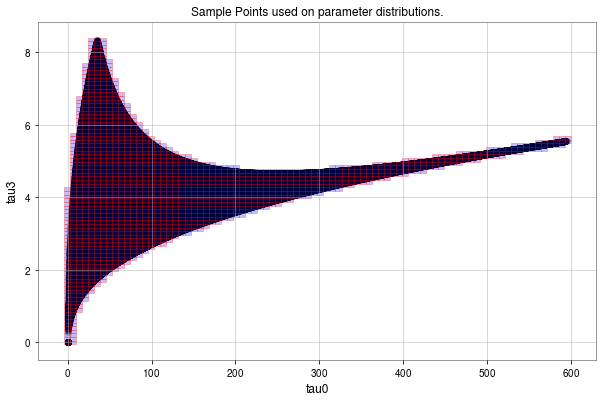

In [88]:
xParam = 'tau0'
yParam = 'tau3'

# xParam = 'mass1'
# yParam = 'mass2'

#xParam = 'eta'
#yParam = 'chirpMass'

# bankParameters['logChirpMass'] = np.log(bankParameters['chirpMass'])
# realTriggersH1['logChirpMass'] = np.log(realTriggersH1['chirpMass'])
# realTriggersL1['logChirpMass'] = np.log(realTriggersL1['chirpMass'])
# fakeTriggersH1['logChirpMass'] = np.log(fakeTriggersH1['chirpMass'])
# fakeTriggersL1['logChirpMass'] = np.log(fakeTriggersL1['chirpMass'])

# xParam = 'eta'
# yParam = 'logChirpMass'


underEstimate = False

overlap = False

nPoints = 1000

#-----------------------------------------------------

minX = np.min(bankParameters[xParam].values)
maxX = np.max(bankParameters[xParam].values)
minY = np.min(bankParameters[yParam].values)
maxY = np.max(bankParameters[yParam].values)
xRange = maxX - minX
yRange = maxY - minY
minX -= 0.05*xRange
maxX += 0.05*xRange
minY -= 0.05*yRange
maxY += 0.05*yRange

allXParam = bankParameters[xParam].values
allYParam = bankParameters[yParam].values


totalArea = (maxX-minX)*(maxY-minY)
estimatedArea = np.pi*np.std(allXParam)*np.std(allYParam)

estimatedRatio = estimatedArea/totalArea

xs = []
ys = []

n0 = int(np.round(np.sqrt(nPoints/estimatedRatio)))
print("Splitting parameter space into uniform " + str(n0) + "x" + str(n0) + " grid.")
xBack = np.linspace(minX, maxX, num = n0)
yBack = np.linspace(minY, maxY, num = n0)

for i in range(n0):
    clear_output()
    print("Splitting parameter space into uniform " + str(n0) + "x" + str(n0) + " grid.")
    print(str(i) + ' / ' + str(n0))
    for j in range(n0):
        if (i > 0 and i < n0 - 1) and (j > 0 and j < n0 - 1):
            if underEstimate:
                pointIn = True in (allXParam >= xBack[i])*(allXParam <= xBack[i+1])*(allYParam >= yBack[j])*(allYParam <= yBack[j+1]) and \
                True in (allXParam >= xBack[i-1])*(allXParam <= xBack[i])*(allYParam >= yBack[j])*(allYParam <= yBack[j+1]) and \
                True in (allXParam >= xBack[i])*(allXParam <= xBack[i+1])*(allYParam >= yBack[j-1])*(allYParam <= yBack[j]) and \
                True in (allXParam >= xBack[i-1])*(allXParam <= xBack[i])*(allYParam >= yBack[j-1])*(allYParam <= yBack[j])
            else:
                pointIn = True in (allXParam >= xBack[i])*(allXParam <= xBack[i+1])*(allYParam >= yBack[j])*(allYParam <= yBack[j+1]) or \
                True in (allXParam >= xBack[i-1])*(allXParam <= xBack[i])*(allYParam >= yBack[j])*(allYParam <= yBack[j+1]) or \
                True in (allXParam >= xBack[i])*(allXParam <= xBack[i+1])*(allYParam >= yBack[j-1])*(allYParam <= yBack[j]) or \
                True in (allXParam >= xBack[i-1])*(allXParam <= xBack[i])*(allYParam >= yBack[j-1])*(allYParam <= yBack[j])        
            if pointIn:
                xs += [xBack[i]]
                ys += [yBack[j]]
                
clear_output()
print("Splitting parameter space into uniform " + str(n0) + "x" + str(n0) + " grid.")
print("Number of squares covering region: " + str(len(xs)))
print("Calculating Regions")

regions = []
    
xStep = xBack[1] - xBack[0]
yStep = yBack[1] - yBack[0]
if not overlap:
    xStep = xStep/2
    yStep = yStep/2
    
for i in range(len(xs)):
    regions += [[(xs[i] - xStep, xs[i] + xStep),(ys[i] - yStep, ys[i] + yStep)]]
                

print("Creating Plots")
        
fig, ax = plt.subplots(figsize = [10, 10/1.61])
ax.scatter(allXParam, allYParam, color = 'k', alpha = 0.01)
#ax.scatter(xs, ys, color = 'b')
ax.set_xlabel(xParam)
ax.set_ylabel(yParam)
ax.set_title("Sample Points used on parameter distributions.")

regions = []
for i in range(len(xs)):
    rect = patches.Rectangle((xs[i]-xStep, ys[i]-yStep), 2*xStep, 2*yStep, linewidth=1, edgecolor='red', facecolor='blue', alpha = 0.25)
    ax.add_patch(rect)
    regions += [[(xs[i]-xStep, xs[i]+xStep), (ys[i]-yStep, ys[i]+yStep)]]
regionPlotxLim = ax.get_xlim()
regionPlotyLim = ax.get_ylim()

In [89]:
fig.savefig("ResultsPlots/Isolated_Regions_In_Parameter_Space_tau0_tau3.png")
# fig.savefig("ResultsPlots/Isolated_Regions_In_Parameter_Space_eta_logMchirp.png")

In [ ]:
## Making lists of banks for each region
triggersH1Real = []
triggersH1RealSNR = []
triggersH1RealCHISQ = []
triggersL1Real = []
triggersL1RealSNR = []
triggersL1RealCHISQ = []
triggersCompareFake = []
triggersCompareFakeSNR = []
triggersCompareFakeCHISQ = []
triggersControlFake = []
triggersControlFakeSNR = []
triggersControlFakeCHISQ = []
region_xi = []
region_yi = []
region_xf = []
region_yf = []

i = 0
for region in regions:
    region_xi += [region[0][0]]
    region_xf += [region[0][1]]
    region_yi += [region[1][0]]
    region_yf += [region[1][1]]
    
    clear_output()
    print(str(i) + " / " + str(len(regions)))
    i += 1
    temp = realTriggersH1[realTriggersH1[xParam] >= region[0][0]]
    temp = temp[temp[xParam] <= region[0][1]]
    temp = temp[temp[yParam] >= region[1][0]]
    temp = temp[temp[yParam] <= region[1][1]]
    triggersH1Real += [temp.index.values]
    triggersH1RealSNR += [temp['snr'].values]
    triggersH1RealCHISQ += [temp['chisq'].values]

    temp = realTriggersL1[realTriggersL1[xParam] >= region[0][0]]
    temp = temp[temp[xParam] <= region[0][1]]
    temp = temp[temp[yParam] >= region[1][0]]
    temp = temp[temp[yParam] <= region[1][1]]
    triggersL1Real += [temp.index.values]
    triggersL1RealSNR += [temp['snr'].values]
    triggersL1RealCHISQ += [temp['chisq'].values]

    temp = fakeTriggersCompare[fakeTriggersCompare[xParam] >= region[0][0]]
    temp = temp[temp[xParam] <= region[0][1]]
    temp = temp[temp[yParam] >= region[1][0]]
    temp = temp[temp[yParam] <= region[1][1]]
    triggersCompareFake += [temp.index.values]
    triggersCompareFakeSNR += [temp['snr'].values]
    triggersCompareFakeCHISQ += [temp['chisq'].values]
    
    temp = fakeTriggersControl[fakeTriggersControl[xParam] >= region[0][0]]
    temp = temp[temp[xParam] <= region[0][1]]
    temp = temp[temp[yParam] >= region[1][0]]
    temp = temp[temp[yParam] <= region[1][1]]
    triggersControlFake += [temp.index.values]
    triggersControlFakeSNR += [temp['snr'].values]
    triggersControlFakeCHISQ += [temp['chisq'].values]
    
regions = {'region':regions}

regions['xi'] = region_xi
regions['xf'] = region_xf
regions['yi'] = region_yi
regions['yf'] = region_yf

regions['real_H1_Triggers'] = triggersH1Real
regions['real_H1_snr'] = triggersH1RealSNR
regions['real_H1_chisq'] = triggersH1RealCHISQ

regions['real_L1_Triggers'] = triggersL1Real
regions['real_L1_snr'] = triggersL1RealSNR
regions['real_L1_chisq'] = triggersL1RealCHISQ

regions['fake_Compare_Triggers'] = triggersCompareFake
regions['fake_Compare_snr'] = triggersCompareFakeSNR
regions['fake_Compare_chisq'] = triggersCompareFakeCHISQ

regions['fake_Control_Triggers'] = triggersControlFake
regions['fake_Control_snr'] = triggersControlFakeSNR
regions['fake_Control_chisq'] = triggersControlFakeCHISQ

regions = pd.DataFrame(regions) 

regions['real_H1_snr_N'] = [len(regions.iloc[i]['real_H1_snr']) for i in range(len(regions))]
regions['real_L1_snr_N'] = [len(regions.iloc[i]['real_L1_snr']) for i in range(len(regions))]
regions['fake_Compare_snr_N'] = [len(regions.iloc[i]['fake_Compare_snr']) for i in range(len(regions))]
regions['fake_Control_snr_N'] = [len(regions.iloc[i]['fake_Compare_snr']) for i in range(len(regions))]

regions['real_H1_chisq_N'] = [len(regions.iloc[i]['real_H1_chisq']) for i in range(len(regions))]
regions['real_L1_chisq_N'] = [len(regions.iloc[i]['real_L1_chisq']) for i in range(len(regions))]
regions['fake_Compare_chisq_N'] = [len(regions.iloc[i]['fake_Compare_chisq']) for i in range(len(regions))]
regions['fake_Control_chisq_N'] = [len(regions.iloc[i]['fake_Control_chisq']) for i in range(len(regions))]

with open("regions_1000.pkl", 'wb') as f:
    pkl.dump(regions, f)

In [92]:
with open("regions_1000.pkl", 'rb') as f:
    regions = pkl.load(f)

2 / 3 | 0 / 10


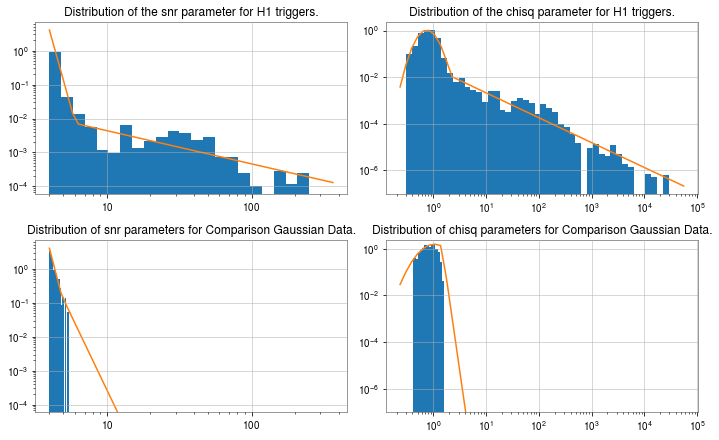

In [119]:
def opt_snr(optIterations, nGran, rangeP1, rangeP2, rangeP3, model, verbose = True):
    bestCost = 100000000000000
    bestParams = [np.mean(rangeP1), np.mean(rangeP2), np.mean(rangeP3)]
    for i in range(optIterations):
        l = 0
        for p1 in np.linspace(rangeP1[0], rangeP1[1], num = nGran):
            if verbose:
                clear_output()
                print(str(i) + " / " + str(optIterations) + " | " + str(l) + " / " + str(nGran))
            for p2 in np.linspace(rangeP2[0], rangeP2[1], num = nGran):
                for p3 in np.linspace(rangeP3[0], rangeP3[1], num = nGran):
                    yTest = model(xx, p1, p2, p3)
                    cost = sum((yTest - yy)**2)
                    if cost < bestCost:
                        bestCost = cost
                        bestParams = [p1, p2, p3]
        l += 1
        rangeP1 = [bestParams[0] - (rangeP1[-1] - rangeP1[0])/nGran, bestParams[0] + (rangeP1[-1] - rangeP1[0])/nGran]
        rangeP2 = [bestParams[1] - (rangeP2[-1] - rangeP2[0])/nGran, bestParams[1] + (rangeP2[-1] - rangeP2[0])/nGran]
        rangeP3 = [bestParams[2] - (rangeP3[-1] - rangeP3[0])/nGran, bestParams[2] + (rangeP3[-1] - rangeP3[0])/nGran]
    return bestParams

def opt_chisq(optIterations, nGran, rangeP1, rangeP2, model, verbose = True):
    bestCost = 100000000000000
    bestParams = [np.mean(rangeP1), np.mean(rangeP2)]
    for i in range(optIterations):
        l = 0
        for p1 in np.linspace(rangeP1[0], rangeP1[1], num = nGran):
            if verbose:
                clear_output()
                print(str(i) + " / " + str(optIterations) + " | " + str(l) + " / " + str(nGran))
            for p2 in np.linspace(rangeP2[0], rangeP2[1], num = nGran):
                yTest = model(xx, p1, p2)
                cost = sum((yTest - yy)**2)
                if cost < bestCost:
                    bestCost = cost
                    bestParams = [p1, p2]
        l += 1
        rangeP1 = [bestParams[0] - (rangeP1[-1] - rangeP1[0])/nGran, bestParams[0] + (rangeP1[-1] - rangeP1[0])/nGran]
        rangeP2 = [bestParams[1] - (rangeP2[-1] - rangeP2[0])/nGran, bestParams[1] + (rangeP2[-1] - rangeP2[0])/nGran]
    return bestParams

idx = 11
fit_n = 50
variables = ['real_H1_snr', 'real_H1_chisq','fake_Compare_snr', 'fake_Compare_chisq']

minxLim_snr = 1e99
maxxLim_snr = 0
minyLim_snr = 1e99
maxyLim_snr = 0

minxLim_chisq = 1e99
maxxLim_chisq = 0
minyLim_chisq = 1e99
maxyLim_chisq = 0

fig, ax = plt.subplots(2, 2, figsize = [10, 10/1.61])
vN = 0
for variable in variables:
    i = int(vN/2)
    j = vN % 2
    f = regions.iloc[idx][variable]
    xRange = [min(f), max(f)]
    bw_f = bestbandwidth(f)
    bins = np.exp(np.linspace(np.log(xRange[0]), np.log(xRange[1]), num = int((xRange[-1]-xRange[0])/bw_f)))
    heights, xs = np.histogram(f, bins = bins, density = True)
    xs = [(xs[i]+xs[i+1])/2 for i in range(len(xs)-1)]
    x = []
    y = []
    for k in range(len(xs)):
        if heights[k] != 0:
            x += [xs[k]]
            y += [heights[k]]
    xx = np.log(np.array(x))
    yy = np.log(np.array(y))

    y0 = yy[0]
    x0 = xx[0]
    yMax = max(yy)
    xMax = xx[np.argmax(yy)] - x0

    def model_snr(x, a1, a2, xc):
        y = []
        for X in x:
            if X < xc:
                y += [y0 + (X - x0)*a1]
            elif X >= xc:
                y += [y0 + (xc - x0)*(a1 - a2) + (X - x0)*a2]

        return np.array(y)

    def model_chisq(x, a1, xc):
        y = []
        a = (y0-yMax)/(xMax**2)
        b = -(2*(y0 - yMax)/xMax)
        c = y0
        for X in x:
            if X < xc:
                y += [a*(X - x0)**2 + b*(X - x0) + c]
            elif X >= xc:
                y += [a1*(X - x0) + a*(xc - x0)**2 + (b - a1)*(xc - x0) + c]

        return np.array(y)
    
    optIterations = 3
    nGran = 10

#     fit_x = np.linspace(np.log(xRange[0]), np.log(xRange[1]), num = fit_n)
    if 'snr' in variable:
        fit_x = np.linspace(np.log(min(regions['real_H1_snr'].values[0])), np.log(max(regions['real_H1_snr'].values[0])), num = fit_n)
        rangeP1 = [0,-20]
        rangeP2 = [0,-20]
        rangeP3 = [min(xx), max(xx)]
        popt = opt_snr(optIterations, nGran, rangeP1, rangeP2, rangeP3, model_snr, verbose = True)
        y_f = model_snr(fit_x, popt[0], popt[1], popt[2])
    elif 'chisq' in variable:
        fit_x = np.linspace(np.log(min(regions['real_H1_chisq'].values[0])), np.log(max(regions['real_H1_chisq'].values[0])), num = fit_n)
        rangeP1 = [0,-20]
        rangeP2 = [xMax, max(xx)]
        popt = opt_chisq(optIterations, nGran, rangeP1, rangeP2, model_chisq, verbose = True)
        y_f = model_chisq(fit_x, popt[0], popt[1])

    ax[i, j].hist(f, bins = bins, density = True, label = 'Parameter Distribution')
    ax[i, j].plot(np.exp(fit_x), np.exp(y_f), label = 'Fit')
    ax[i, j].set_xscale('log')
    ax[i, j].set_yscale('log')
    ax[i, j].set_title(variable)
    xLim = ax[i, j].get_xlim()
    yLim = ax[i, j].get_ylim()
    if 'snr' in variable and 'real' in variable:
        ax[i, j].set_title("Distribution of the snr parameter for H1 triggers.")
        if xLim[0] < minxLim_snr:
            minxLim_snr = xLim[0]
        if xLim[1] > maxxLim_snr:
            maxxLim_snr = xLim[1]
        if yLim[0] < minyLim_snr:
            minyLim_snr = yLim[0]
        if yLim[1] > maxyLim_snr:
            maxyLim_snr = yLim[1]
    elif 'chisq' in variable and 'real' in variable:
        ax[i, j].set_title("Distribution of the chisq parameter for H1 triggers.")
        if xLim[0] < minxLim_chisq:
            minxLim_chisq = xLim[0]
        if xLim[1] > maxxLim_chisq:
            maxxLim_chisq = xLim[1]
        if yLim[0] < minyLim_chisq:
            minyLim_chisq = yLim[0]
        if yLim[1] > maxyLim_chisq:
            maxyLim_chisq = yLim[1]    
    elif 'Compare' in variable and 'snr' in variable:
        ax[i, j].set_title("Distribution of snr parameters for Comparison Gaussian Data.")
    elif 'Compare' in variable and 'chisq' in variable:
        ax[i, j].set_title("Distribution of chisq parameters for Comparison Gaussian Data.")
        
    vN += 1

for i in range(len(ax)):
    for j in range(len(ax[i])):
        if 'snr' in ax[i, j].get_title():
            ax[i, j].set_xlim([minxLim_snr, maxxLim_snr])
            ax[i, j].set_ylim([minyLim_snr, maxyLim_snr])
        elif 'chisq' in ax[i, j].get_title():
            ax[i, j].set_xlim([minxLim_chisq, maxxLim_chisq])
            ax[i, j].set_ylim([minyLim_chisq, maxyLim_chisq])
fig.tight_layout()

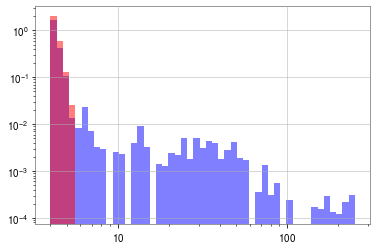

In [160]:
fig, ax = plt.subplots()
f1 = regions.iloc[11]['real_H1_snr']
f2 = regions.iloc[11]['fake_Compare_snr']

bins = np.exp(np.linspace(np.log(min(f1)),np.log(max(f1)), num = 50))

ax.hist(f1, density = True, color = 'blue', alpha = 0.5, bins = bins)
ax.hist(f2, density = True, color = 'red', alpha = 0.5, bins = bins)
ax.set_xscale('log')
ax.set_yscale('log')

## Fit Blue, re-do plots, Add L1

In [120]:
fig.savefig("ResultsPlots/Distribution_of_parameters_for_H1_real_and_Gaussian_Data.png")

### Finding optimal parameters for each region in all variables

In [58]:
def opt_snr(optIterations, nGran, rangeP1, rangeP2, rangeP3, model, verbose = True):
    bestCost = 100000000000000
    bestParams = [np.mean(rangeP1), np.mean(rangeP2), np.mean(rangeP3)]
    for i in range(optIterations):
        l = 0
        for p1 in np.linspace(rangeP1[0], rangeP1[1], num = nGran):
            if verbose:
                clear_output()
                print(str(i) + " / " + str(optIterations) + " | " + str(l) + " / " + str(nGran))
            for p2 in np.linspace(rangeP2[0], rangeP2[1], num = nGran):
                for p3 in np.linspace(rangeP3[0], rangeP3[1], num = nGran):
                    yTest = model(xx, p1, p2, p3)
                    cost = sum((yTest - yy)**2)
                    if cost < bestCost:
                        bestCost = cost
                        bestParams = [p1, p2, p3]
        l += 1
        rangeP1 = [bestParams[0] - (rangeP1[-1] - rangeP1[0])/nGran, bestParams[0] + (rangeP1[-1] - rangeP1[0])/nGran]
        rangeP2 = [bestParams[1] - (rangeP2[-1] - rangeP2[0])/nGran, bestParams[1] + (rangeP2[-1] - rangeP2[0])/nGran]
        rangeP3 = [bestParams[2] - (rangeP3[-1] - rangeP3[0])/nGran, bestParams[2] + (rangeP3[-1] - rangeP3[0])/nGran]
    return bestParams

def opt_chisq(optIterations, nGran, rangeP1, rangeP2, model, verbose = True):
    bestCost = 100000000000000
    bestParams = [np.mean(rangeP1), np.mean(rangeP2)]
    for i in range(optIterations):
        l = 0
        for p1 in np.linspace(rangeP1[0], rangeP1[1], num = nGran):
            if verbose:
                clear_output()
                print(str(i) + " / " + str(optIterations) + " | " + str(l) + " / " + str(nGran))
            for p2 in np.linspace(rangeP2[0], rangeP2[1], num = nGran):
                yTest = model(xx, p1, p2)
                cost = sum((yTest - yy)**2)
                if cost < bestCost:
                    bestCost = cost
                    bestParams = [p1, p2]
        l += 1
        rangeP1 = [bestParams[0] - (rangeP1[-1] - rangeP1[0])/nGran, bestParams[0] + (rangeP1[-1] - rangeP1[0])/nGran]
        rangeP2 = [bestParams[1] - (rangeP2[-1] - rangeP2[0])/nGran, bestParams[1] + (rangeP2[-1] - rangeP2[0])/nGran]
    return bestParams

fit_n = 200
variables = ['real_H1_snr', 'real_H1_chisq', 'real_L1_snr', 'real_L1_chisq', 'fake_Compare_snr', 'fake_Compare_chisq', 'fake_Control_snr', 'fake_Control_chisq']
popts = {variable:[] for variable in variables}
fits = {variable:[] for variable in variables}

for idx in range(len(regions)):
    clear_output()
    print(str(idx) + " / " + str(len(regions)))
    for variable in variables:
        f = regions.iloc[idx][variable]
        if len(f) > 0:
            xRange = [min(f), max(f)]
            bw_f = bestbandwidth(f)
            bins = np.exp(np.linspace(np.log(xRange[0]), np.log(xRange[1]), num = int((xRange[-1]-xRange[0])/bw_f)))
            heights, xs = np.histogram(f, bins = bins, density = True)
            xs = [(xs[i]+xs[i+1])/2 for i in range(len(xs)-1)]
            x = []
            y = []
            for k in range(len(xs)):
                if heights[k] != 0:
                    x += [xs[k]]
                    y += [heights[k]]
            xx = np.log(np.array(x))
            yy = np.log(np.array(y))

            y0 = yy[0]
            x0 = xx[0]
            yMax = max(yy)
            xMax = xx[np.argmax(yy)] - x0

            def model_snr(x, a1, a2, xc):
                y = []
                for X in x:
                    if X < xc:
                        y += [y0 + (X - x0)*a1]
                    elif X >= xc:
                        y += [y0 + (xc - x0)*(a1 - a2) + (X - x0)*a2]

                return np.array(y)

            def model_chisq(x, a1, xc):
                y = []
                a = (y0-yMax)/(xMax**2)
                b = -(2*(y0 - yMax)/xMax)
                c = y0
                for X in x:
                    if X < xc:
                        y += [a*(X - x0)**2 + b*(X - x0) + c]
                    elif X >= xc:
                        y += [a1*(X - x0) + a*(xc - x0)**2 + (b - a1)*(xc - x0) + c]

                return np.array(y)

            optIterations = 3
            nGran = 10

            fit_x = np.linspace(np.log(xRange[0]), np.log(xRange[1]), num = fit_n)
            if 'snr' in variable:
                rangeP1 = [0,-20]
                rangeP2 = [0,-20]
                rangeP3 = [min(xx), max(xx)]
                popt = opt_snr(optIterations, nGran, rangeP1, rangeP2, rangeP3, model_snr, verbose = False)
                y_fit = np.exp(model_snr(fit_x, popt[0], popt[1], popt[2]))
            elif 'chisq' in variable:
                rangeP1 = [0,-20]
                rangeP2 = [xMax, max(xx)]
                popt = opt_chisq(optIterations, nGran, rangeP1, rangeP2, model_chisq, verbose = False)
                y_fit = np.exp(model_chisq(fit_x, popt[0], popt[1]))
                
            popts[variable] += [popt]
            fits[variable] += [y_fit/np.sqrt(np.sum(y_fit**2))]
        else:
            popts[variable] += [np.nan]
            fits[variable] += [np.nan]
for variable in variables:
    regions[variable + "_popt"] = popts[variable]
    regions[variable + "_fit"] = fits[variable]
    
with open("regions_1000.pkl", 'wb') as f:
    pkl.dump(regions, f)

1351 / 1352


In [ ]:
with open("regions_1000.pkl", 'rb') as f:
    regions = pkl.load(f)

## Applying Correlation Measure

In [59]:
fit_n = 200
variables = ['real_H1_snr', 'real_H1_chisq', 'real_L1_snr', 'real_L1_chisq', 'fake_Compare_snr', 'fake_Compare_chisq', 'fake_Control_snr', 'fake_Control_chisq']
popts = {variable:[] for variable in variables}

compare_H1_snr_Col = []
compare_L1_snr_Col = []
control_snr_Col = []

compare_H1_chisq_Col = []
compare_L1_chisq_Col = []
control_chisq_Col = []



for idx in range(len(regions)):
    clear_output()
    print(str(idx) + " / " + str(len(regions)))
    region = regions.iloc[idx]
    if len(region['real_H1_snr']) > 0:
        H1_snr_fit = region['real_H1_snr_fit']
        L1_snr_fit = region['real_L1_snr_fit']
        Compare_snr_fit = region['fake_Compare_snr_fit']
        Control_snr_fit = region['fake_Control_snr_fit']

        H1_chisq_fit = region['real_H1_chisq_fit']
        L1_chisq_fit = region['real_L1_chisq_fit']
        Compare_chisq_fit = region['fake_Compare_chisq_fit']
        Control_chisq_fit = region['fake_Control_chisq_fit']

        compare_H1_snr_Col += [np.sum(H1_snr_fit*Compare_snr_fit)]
        compare_L1_snr_Col += [np.sum(L1_snr_fit*Compare_snr_fit)]
        control_snr_Col += [np.sum(Compare_snr_fit*Control_snr_fit)]

        compare_H1_chisq_Col += [np.sum(H1_chisq_fit*Compare_chisq_fit)]
        compare_L1_chisq_Col += [np.sum(L1_chisq_fit*Compare_chisq_fit)]
        control_chisq_Col += [np.sum(Compare_chisq_fit*Control_chisq_fit)]
    else:                    
        compare_H1_snr_Col += [np.nan]
        compare_L1_snr_Col += [np.nan]
        control_snr_Col += [np.nan]

        compare_H1_chisq_Col += [np.nan]
        compare_L1_chisq_Col += [np.nan]
        control_chisq_Col += [np.nan]
    
regions['H1_snr_Compare'] = compare_H1_snr_Col
regions['L1_snr_Compare'] = compare_L1_snr_Col
regions['snr_Control'] = control_snr_Col
regions['H1_chisq_Compare'] = compare_H1_chisq_Col
regions['L1_chisq_Compare'] = compare_L1_chisq_Col
regions['chisq_Control'] = control_chisq_Col

with open("regions_1000.pkl", 'wb') as f:
    pkl.dump(regions, f)

1351 / 1352


In [ ]:
with open("regions_1000.pkl", 'rb') as f:
    regions = pkl.load(f)

### Distribution of SNR and CHISQ correlation comparison across all regions for H1 and L1

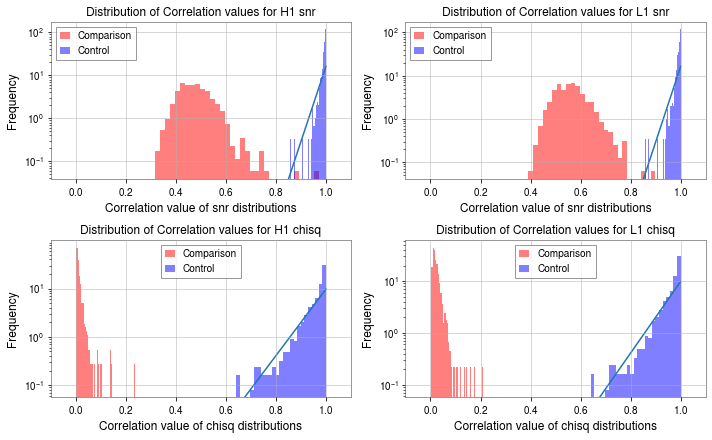

In [127]:
fig, ax = plt.subplots(2, 2, figsize = [10, 10/1.61])
i = 0
for param in ['snr','chisq']:
    j = 0
    for ifo in ['H1','L1']:
        compareList = regions[ifo + '_' + param + '_Compare'].dropna().values
        controlList = regions[param + '_Control'].dropna().values
        
        xRangeCompare = [min(compareList), max(compareList)]
        xRangeControl = [min(controlList), max(controlList)]
        bwCompare = bestbandwidth(compareList)
        bwControl = bestbandwidth(controlList)
        binsCompare = np.linspace(xRangeCompare[0], xRangeCompare[1], num = int((xRangeCompare[1]-xRangeCompare[0])/bwCompare))
        binsControl = np.linspace(xRangeControl[0], xRangeControl[1], num = int((xRangeControl[1]-xRangeControl[0])/bwControl))
        
        ax[i, j].hist(compareList, bins = binsCompare, color = 'red', alpha = 0.5, density = True, label = 'Comparison')
        ax[i, j].hist(controlList, bins = binsControl, color = 'blue', alpha = 0.5, density = True, label = 'Control')
        ax[i, j].set_yscale('log')
        ax[i, j].legend()
        ax[i, j].set_title('Distribution of Correlation values for ' + ifo + ' ' + param)
        ax[i, j].set_xlabel('Correlation value of ' + param + ' distributions')
        ax[i, j].set_ylabel('Frequency')
        ax[i, j].set_xlim([-.1, 1.1])
        ylim = ax[i, j].get_ylim()        
        
        hCompare, xCompare = np.histogram(compareList, bins = binsCompare, density = True)
        xCompare = [(xCompare[i]+xCompare[i+1])/2 for i in range(len(xCompare)-1)]
        
        hControl, xControl = np.histogram(controlList, bins = binsControl, density = True)
        xControl = [(xControl[i]+xControl[i+1])/2 for i in range(len(xControl)-1)]

        x = []
        y = []
        for k in range(len(xControl)):
            if hControl[k] != 0:
                x += [xControl[k]]
                y += [hControl[k]]
        x = np.array(x)
        y = np.log(np.array(y))
              
            
        m, b = np.polyfit(x, y, 1)
#         def modelControlP(x, a):
#             return a*(x - x[-1]) + y[-1]

#         guessSlope = (y[-1]-y[-2])/(x[-1]-x[-2])
#         rangeP1 = [0, 2*guessSlope]
#         bestCost = 10000000000000000
#         bestParams = [0]
#         for p1 in np.linspace(rangeP1[0], rangeP1[1]):
#             yTest = modelControlP(x, p1)
#             cost = sum((yTest - y)**2)
#             if cost < bestCost:
#                 bestCost = cost
#                 bestParams = [p1]
                
#         popt = bestParams
            
        
#         popt, pcov = curve_fit(modelControlP, x, np.log(y),
#                               p0 = (guessSlope, guessIntersect))
        
        xTemp = np.linspace(0,1)
        yTemp = np.exp(m*xTemp + b)
        
        ax[i, j].plot(xTemp, yTemp)
        ax[i, j].set_ylim(ylim)
        
        def integralP(x, bw):
            return 2*np.exp(m*x + b)*np.sinh(bw*m)/m
        
        normalization = integralP(0.5, 0.5)
        
#         def integralP(x, a , b, bw):
#             return (np.exp(a*(x+bw)+b)-np.exp(a*(x-bw)+b))/a/normalization
        
        regions[ifo + '_' + param + '_Gaussian_Probability'] = integralP(regions[ifo + '_' + param + '_Compare'], bwCompare)/normalization
        
        j += 1
    i += 1
fig.tight_layout()

In [128]:
fig.savefig("ResultsPlots/Distribution_of_Correlation_Measure_for_real_and_Gaussian_Data.png")

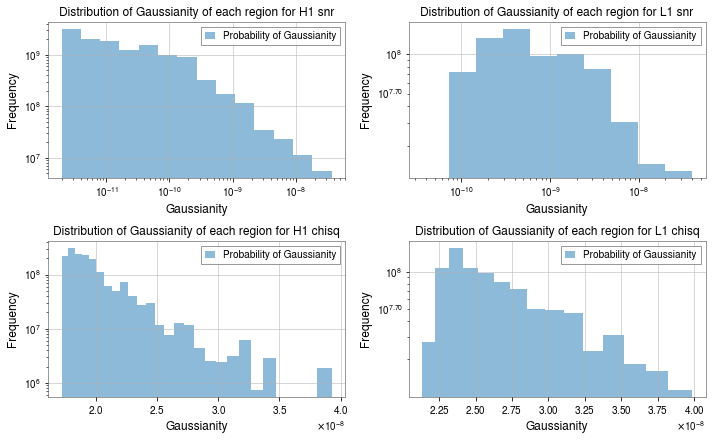

In [164]:
fig, ax = plt.subplots(2, 2, figsize = [10, 10/1.61])
i = 0
regionsTemp = regions.copy()

for param in ['snr','chisq']:
    j = 0
    for ifo in ['H1','L1']:
        regionsTemp = regions[regions[ifo + '_' + param + '_Gaussian_Probability'] < 0.4e-7]
#         regionsTemp = regionsTemp[regionsTemp[ifo + '_' + param + '_Gaussian_Probability'] > 1e-16]
        probList = regionsTemp[ifo + '_' + param + '_Gaussian_Probability'].dropna().values
        
        xRangeProb = [min(probList), max(probList)]

        bwProb = bestbandwidth(probList)
        
        binsProb = np.linspace(xRangeProb[0], xRangeProb[1], num = int((xRangeProb[1]-xRangeProb[0])/bwProb))
        binsProb = np.exp(np.linspace(np.log(xRangeProb[0]), np.log(xRangeProb[1]), num = int((xRangeProb[1]-xRangeProb[0])/bwProb)))
        
        ax[i, j].hist(probList, bins = binsProb, alpha = 0.5, density = True, label = 'Probability of Gaussianity')
        ax[i, j].set_yscale('log')
        if param != 'chisq':
            ax[i, j].set_xscale('log')
        
        ax[i, j].legend()
#         ax[i, j].set_title('Distribution of Correlation values for ' + ifo + ' ' + param)
        ax[i, j].set_xlabel('Gaussianity')
        ax[i, j].set_ylabel('Frequency')
#         ax[i, j].set_xlim([-.1, 1.1])
        ylim = ax[i, j].get_ylim()
        ax[i, j].set_title("Distribution of Gaussianity of each region for " + ifo + " " + param)
        
        j += 1
    i += 1
fig.tight_layout()

In [133]:
fig.savefig("ResultsPlots/Distribution_of_Gaussianity_of_regions.png")

### Interpolating Empty Regions

In [ ]:
regionsTemp = regions.copy()
H1_snr_gaussianProb = []
L1_snr_gaussianProb = []
H1_chisq_gaussianProb = []
L1_chisq_gaussianProb = []

xNorm = max(regions['xi']) - min(regions['xi'])
yNorm = max(regions['yi']) - min(regions['yi'])


interpQ = []
for i in range(len(regions)):
    clear_output()
    print(str(i) + " / " + str(len(regions)))
    region = regions.iloc[i]
    interp = False
    
    ##H1_snr
    if len(region['real_H1_snr']) == 0:
        x = region['xi']
        y = region['yi']
        regionsTemp['distance'] = (x - regionsTemp['xi'])**2/(xNorm**2) + (y - regionsTemp['yi'])**2/(yNorm**2)
        regionsTemp = regionsTemp.sort_values('distance')
        j = 1
        closestRegion = regionsTemp.iloc[j]
        while len(closestRegion['real_H1_snr']) == 0:
            j += 1
            closestRegion = regionsTemp.iloc[j]
        H1_snr_gaussianProb += [closestRegion['H1_snr_Gaussian_Probability']]
        interp = True
    else:
        H1_snr_gaussianProb += [region['H1_snr_Gaussian_Probability']]
    
    ##L1_snr
    if len(region['real_L1_snr']) == 0:
        x = region['xi']
        y = region['yi']
        regionsTemp['distance'] = (x - regionsTemp['xi'])**2/(xNorm**2) + (y - regionsTemp['yi'])**2/(yNorm**2)
        regionsTemp = regionsTemp.sort_values('distance')
        j = 1
        closestRegion = regionsTemp.iloc[j]
        while len(closestRegion['real_L1_snr']) == 0:
            j += 1
            closestRegion = regionsTemp.iloc[j]
        L1_snr_gaussianProb += [closestRegion['L1_snr_Gaussian_Probability']]
        interp = True
    else:
        L1_snr_gaussianProb += [region['L1_snr_Gaussian_Probability']]  
    
    ##H1_chisq
    if len(region['real_H1_chisq']) == 0:
        x = region['xi']
        y = region['yi']
        regionsTemp['distance'] = (x - regionsTemp['xi'])**2/(xNorm**2) + (y - regionsTemp['yi'])**2/(yNorm**2)
        regionsTemp = regionsTemp.sort_values('distance')
        j = 1
        closestRegion = regionsTemp.iloc[j]
        while len(closestRegion['real_H1_chisq']) == 0:
            j += 1
            closestRegion = regionsTemp.iloc[j]
        H1_chisq_gaussianProb += [closestRegion['H1_chisq_Gaussian_Probability']]
        interp = True
    else:
        H1_chisq_gaussianProb += [region['H1_chisq_Gaussian_Probability']]
    
    ##L1_chisq
    if len(region['real_L1_chisq']) == 0:
        x = region['xi']
        y = region['yi']
        regionsTemp['distance'] = (x - regionsTemp['xi'])**2/(xNorm**2) + (y - regionsTemp['yi'])**2/(yNorm**2)
        regionsTemp = regionsTemp.sort_values('distance')
        j = 1
        closestRegion = regionsTemp.iloc[j]
        while len(closestRegion['real_L1_chisq']) == 0:
            j += 1
            closestRegion = regionsTemp.iloc[j]
        L1_chisq_gaussianProb += [closestRegion['L1_chisq_Gaussian_Probability']]
        interp = True
    else:
        L1_chisq_gaussianProb += [region['L1_chisq_Gaussian_Probability']]  
    
    
    
    interpQ += [interp]
regions['H1_snr_Gaussian_Probability'] = H1_snr_gaussianProb
regions['L1_snr_Gaussian_Probability'] = L1_snr_gaussianProb
regions['H1_chisq_Gaussian_Probability'] = H1_chisq_gaussianProb
regions['L1_chisq_Gaussian_Probability'] = L1_chisq_gaussianProb
regions['InterpolatedQ'] = interpQ

### Plotting Region Colors by Gaussianity Magnitude

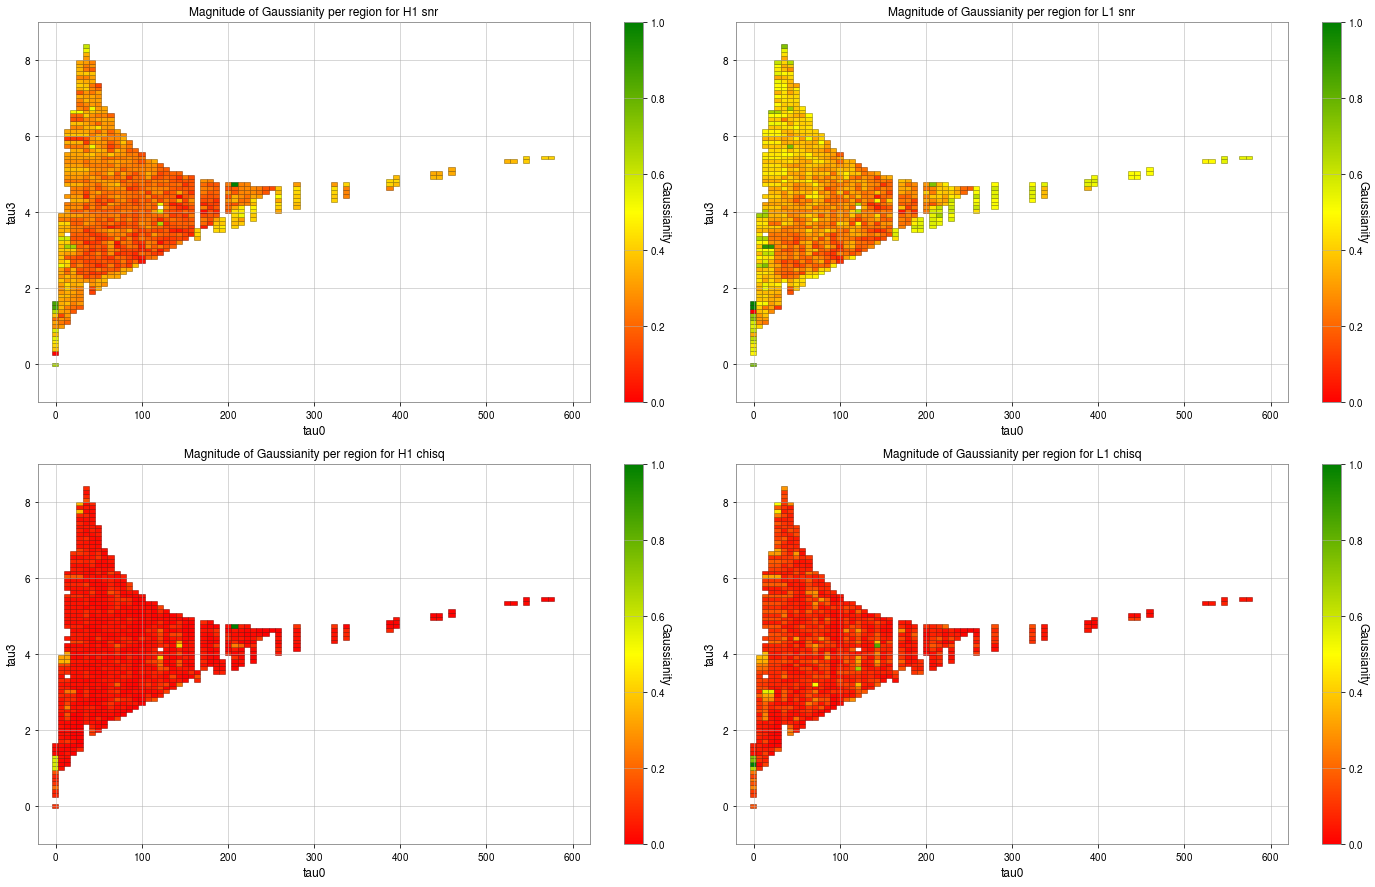

In [255]:
regionPlotxLim = [-20, 620]
regionPlotyLim = [-1, 9]

# cmap = cm.get_cmap('coolwarm')
cmap = LinearSegmentedColormap.from_list("", ["red","yellow","green"])

fig, ax = plt.subplots(2, 2, figsize = [20, 20/1.61])
i = 0
for param in ['snr','chisq']:
    j = 0
    for ifo in ['H1','L1']:
        
        ogPatches = []

        plottingVar = ifo + '_' + param + '_Gaussian_Probability'

        regionsTemp = regions[regions['InterpolatedQ'] == False]

        minVal = min(np.log(regionsTemp[plottingVar].dropna()))
        maxVal = max(np.log(regionsTemp[plottingVar].dropna()))

        for k in range(len(regionsTemp)):
            region = regionsTemp.iloc[k]
            xi = region['xi']
            xf = region['xf']
            yi = region['yi']
            yf = region['yf']

            val = np.log(region[plottingVar])

            colorDiff = cmap((val - minVal)/(maxVal - minVal))
            edgeColor = np.array(colorDiff)/2
            ogPatches += [patches.Rectangle((xi, yi), xf - xi, yf - yi, linewidth=1, edgecolor=edgeColor, facecolor=colorDiff)]

        for patch in ogPatches:
            ax[i, j].add_patch(patch)

        ax[i, j].set_xlim(regionPlotxLim)
        ax[i, j].set_ylim(regionPlotyLim)
        ax[i, j].set_xlabel('tau0')
        ax[i, j].set_ylabel('tau3')
        ax[i, j].set_title('Magnitude of Gaussianity per region for ' + ifo + ' ' + param)
        cbar = fig.colorbar(cm.ScalarMappable(norm = None, cmap=cmap), ax = ax[i, j])
        cbar.set_label('Gaussianity', rotation=270)
               
        j += 1
    i += 1
fig.tight_layout() 

In [256]:
fig.savefig("ResultsPlots/Magnitude_of_Gaussianity_Per_Region.png")

### Plotting Region Colors by Gaussianity Order

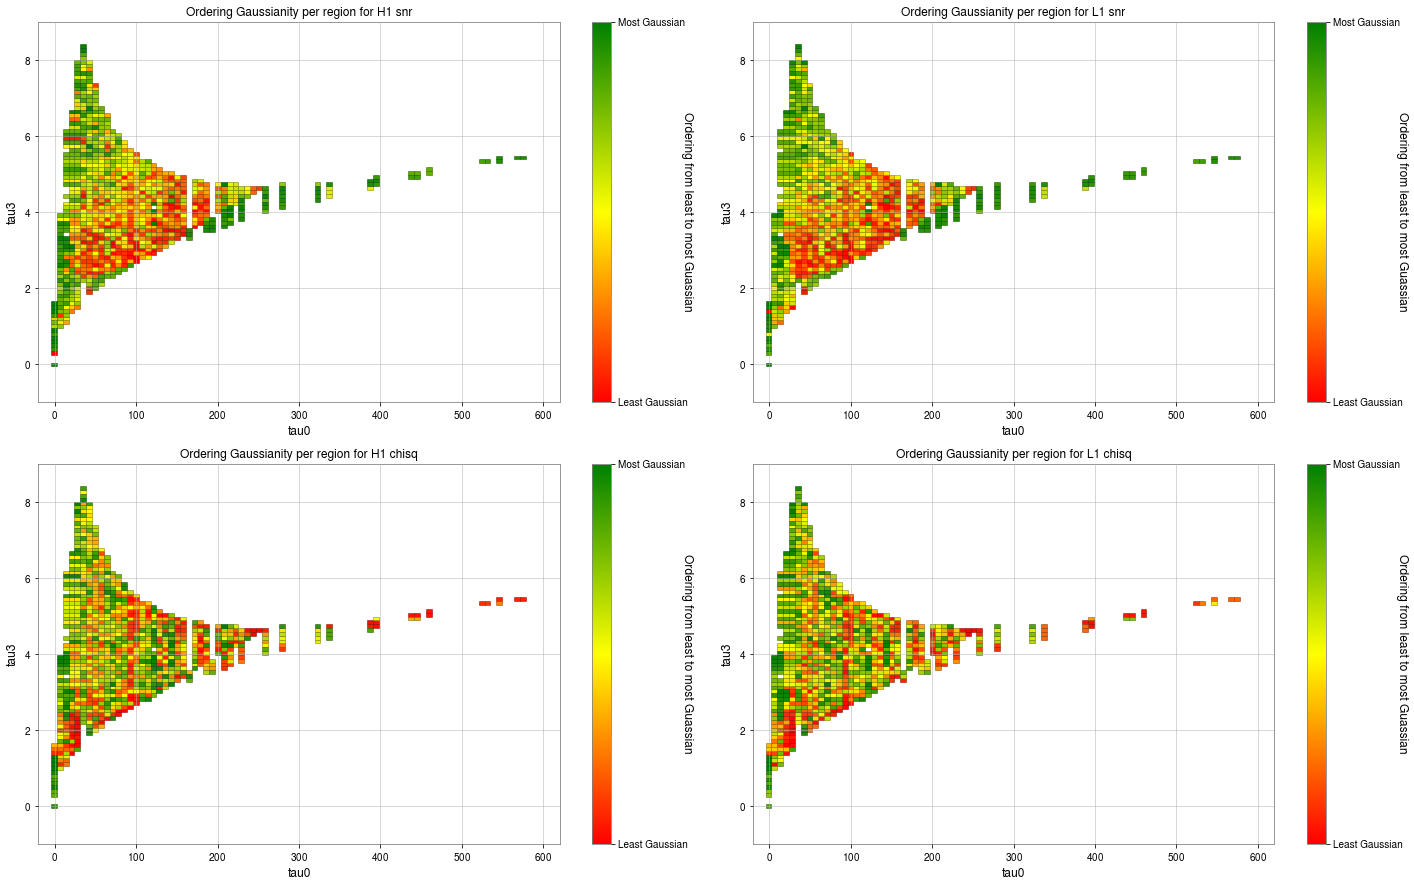

In [265]:
regionPlotxLim = [-20, 620]
regionPlotyLim = [-1, 9]

# cmap = cm.get_cmap('coolwarm')
cmap = LinearSegmentedColormap.from_list("", ["red","yellow","green"])


fig, ax = plt.subplots(2, 2, figsize = [20, 20/1.61])
i = 0
for param in ['snr','chisq']:
    j = 0
    for ifo in ['H1','L1']:
        
        ogPatches = []

        plottingVar = ifo + '_' + param + '_Gaussian_Probability'

        regionsTemp = regions[regions['InterpolatedQ'] == False].sort_values(plottingVar)

        minVal = 0
        maxVal = len(regionsTemp)

        for k in range(len(regionsTemp)):
            region = regionsTemp.iloc[k]
            
            xi = region['xi']
            xf = region['xf']
            yi = region['yi']
            yf = region['yf']

            val = k

            colorDiff = cmap((val - minVal)/(maxVal - minVal))
            edgeColor = np.array(colorDiff)/2
            ogPatches += [patches.Rectangle((xi, yi), xf - xi, yf - yi, linewidth=1, edgecolor=edgeColor, facecolor=colorDiff)]

        for patch in ogPatches:
            ax[i, j].add_patch(patch)

        ax[i, j].set_xlim(regionPlotxLim)
        ax[i, j].set_ylim(regionPlotyLim)
        ax[i, j].set_xlabel('tau0')
        ax[i, j].set_ylabel('tau3')
        ax[i, j].set_title('Ordering Gaussianity per region for ' + ifo + ' ' + param)
        cbar = fig.colorbar(cm.ScalarMappable(norm = None, cmap=cmap), ax = ax[i, j])
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(['Least Gaussian', 'Most Gaussian'])
        cbar.set_label('Ordering from least to most Guassian', rotation=270)
              
        j += 1
    i += 1
fig.tight_layout()  

In [266]:
fig.savefig("ResultsPlots/Ordering_of_Gaussianity_Per_Region.png")

### Plotting Region Colors by Gaussianity Magnitude With Interpolation

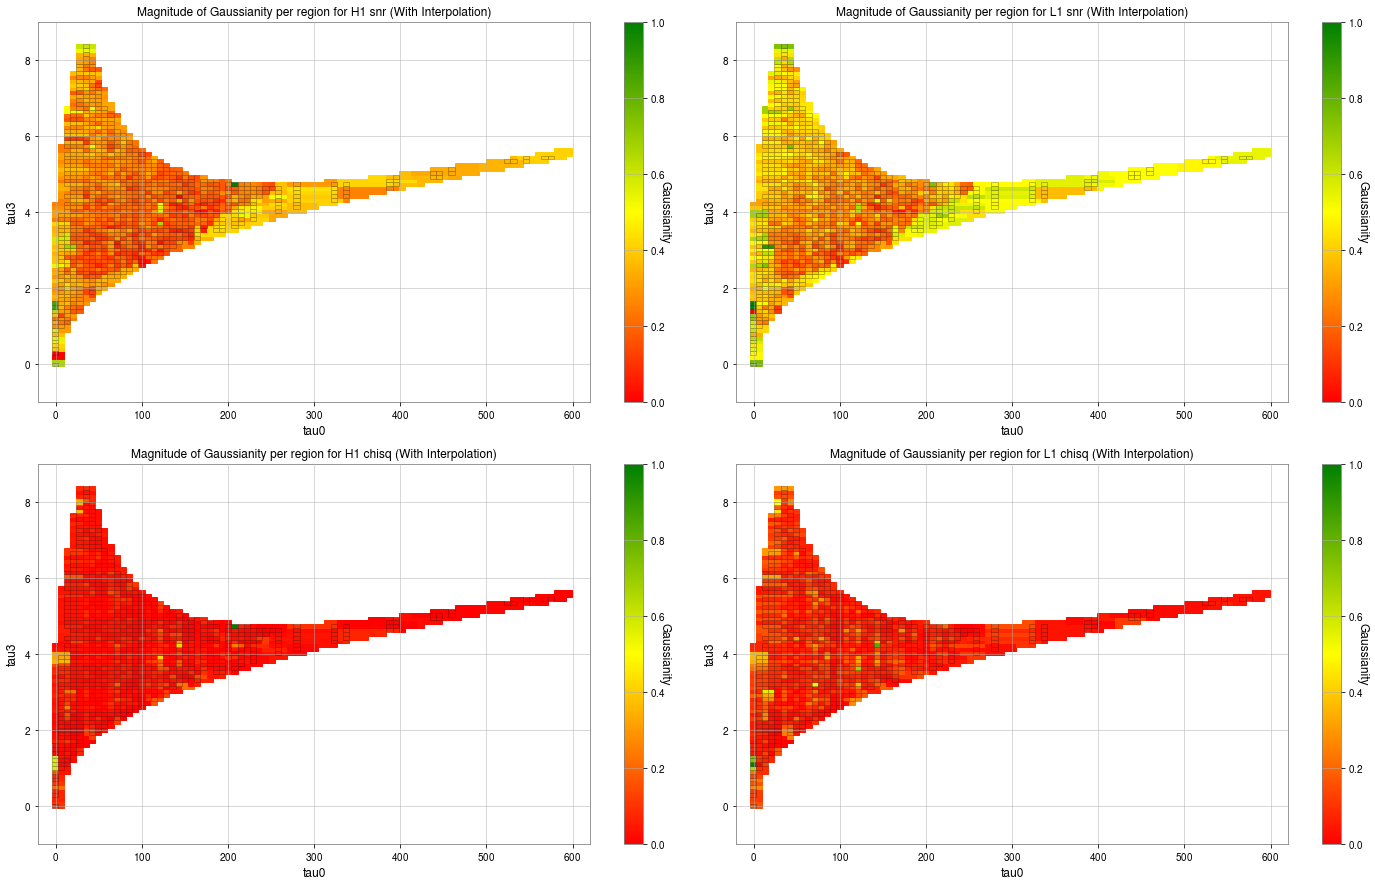

In [259]:
cmap = LinearSegmentedColormap.from_list("", ["red","yellow","green"])
regionsTemp = regions.copy()

fig, ax = plt.subplots(2, 2, figsize = [20, 20/1.61])
i = 0
for param in ['snr','chisq']:
    j = 0
    for ifo in ['H1','L1']:
        
        ogPatches = []
        interpPatches = []

        plottingVar = ifo + '_' + param + '_Gaussian_Probability'

        minVal = np.log(min(regionsTemp[plottingVar].dropna()))
        maxVal = np.log(max(regionsTemp[plottingVar].dropna()))

        for k in range(len(regionsTemp)):
            region = regionsTemp.iloc[k]
            xi = region['xi']
            xf = region['xf']
            yi = region['yi']
            yf = region['yf']

            val = np.log(region[plottingVar])

            colorDiff = cmap((val - minVal)/(maxVal - minVal))
            if region['InterpolatedQ']:
                edgeColor = np.array(colorDiff)
                interpPatches += [patches.Rectangle((xi, yi), xf - xi, yf - yi, linewidth=1, edgecolor=edgeColor, facecolor=colorDiff)]
            else:
                edgeColor = np.array(colorDiff)/2
                ogPatches += [patches.Rectangle((xi, yi), xf - xi, yf - yi, linewidth=1, edgecolor=edgeColor, facecolor=colorDiff)]

        for patch in interpPatches:
            ax[i, j].add_patch(patch)
        for patch in ogPatches:
            ax[i, j].add_patch(patch)
        

        ax[i, j].set_xlim(regionPlotxLim)
        ax[i, j].set_ylim(regionPlotyLim)
        ax[i, j].set_xlabel('tau0')
        ax[i, j].set_ylabel('tau3')
        ax[i, j].set_title('Magnitude of Gaussianity per region for ' + ifo + ' ' + param + ' (With Interpolation)')
        cbar = fig.colorbar(cm.ScalarMappable(norm = None, cmap=cmap), ax = ax[i, j])
        cbar.set_label('Gaussianity', rotation=270)
        
        j += 1
    i += 1
    
fig.tight_layout()
with open("regions_1000.pkl", 'wb') as f:
    pkl.dump(regions, f)
    

In [260]:
fig.savefig("ResultsPlots/Magnitude_of_Gaussianity_Per_Region_With_Interpolation.png")

### Plotting Region Colors by Gaussianity Order With Interpolation

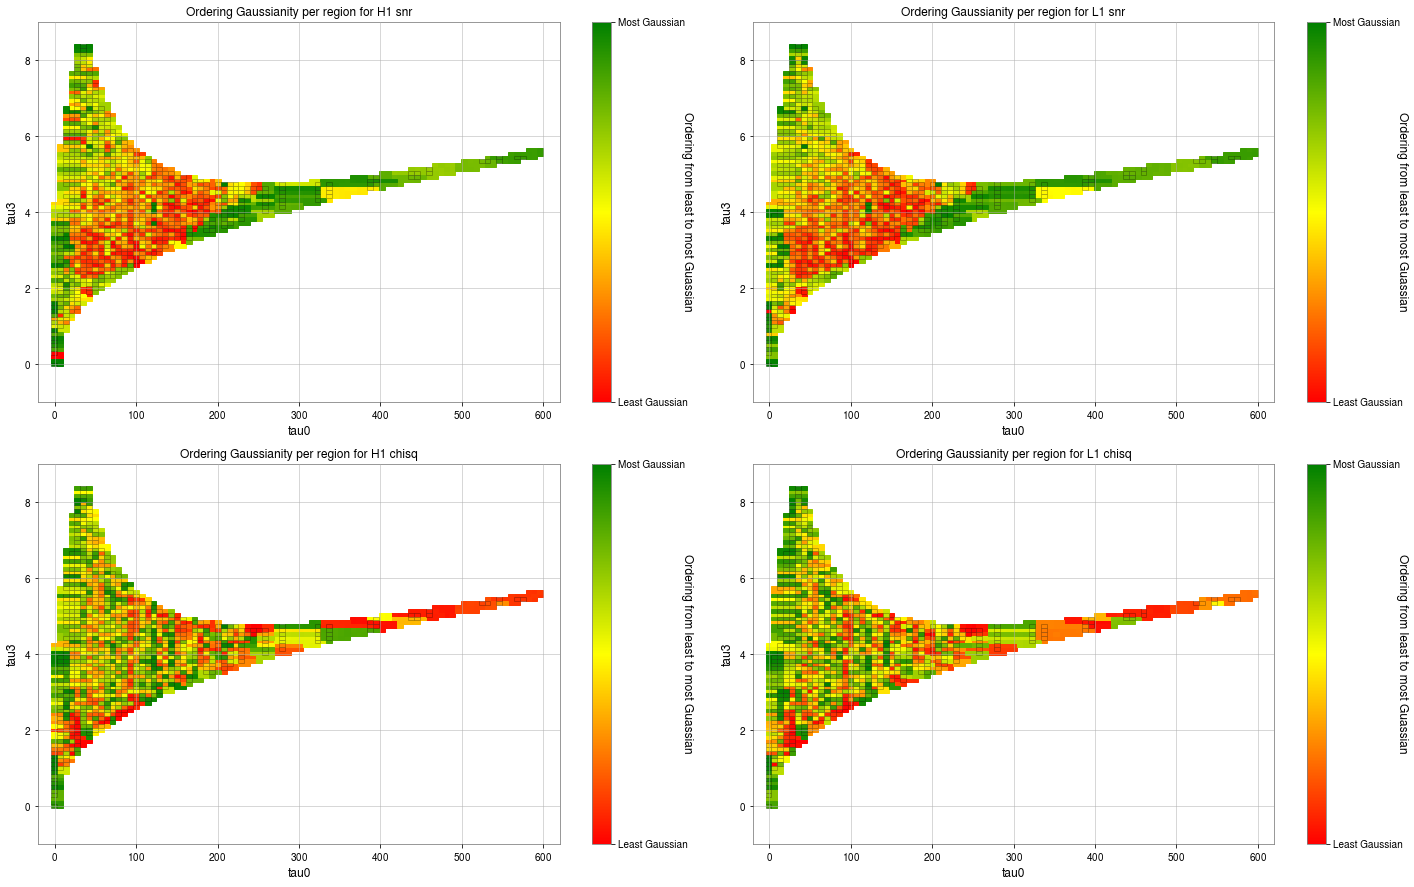

In [269]:
regionPlotxLim = [-20, 620]
regionPlotyLim = [-1, 9]

# cmap = cm.get_cmap('coolwarm')
cmap = LinearSegmentedColormap.from_list("", ["red","yellow","green"])


fig, ax = plt.subplots(2, 2, figsize = [20, 20/1.61])
i = 0
for param in ['snr','chisq']:
    j = 0
    for ifo in ['H1','L1']:
        
        ogPatches = []
        interpPatches = []

        plottingVar = ifo + '_' + param + '_Gaussian_Probability'

        regionsTemp = regions.sort_values(plottingVar)

        minVal = 0
        maxVal = len(regionsTemp)

        for k in range(len(regionsTemp)):
            region = regionsTemp.iloc[k]
            
            xi = region['xi']
            xf = region['xf']
            yi = region['yi']
            yf = region['yf']

            val = k

            colorDiff = cmap((val - minVal)/(maxVal - minVal))
            if region['InterpolatedQ']:
                edgeColor = np.array(colorDiff)
                interpPatches += [patches.Rectangle((xi, yi), xf - xi, yf - yi, linewidth=1, edgecolor=edgeColor, facecolor=colorDiff)]
            else:
                edgeColor = np.array(colorDiff)/2
#                 edgeColor = 'k'
                ogPatches += [patches.Rectangle((xi, yi), xf - xi, yf - yi, linewidth=1, edgecolor=edgeColor, facecolor=colorDiff)]

        for patch in interpPatches:
            ax[i, j].add_patch(patch)
        for patch in ogPatches:
            ax[i, j].add_patch(patch)

        ax[i, j].set_xlim(regionPlotxLim)
        ax[i, j].set_ylim(regionPlotyLim)
        ax[i, j].set_xlabel('tau0')
        ax[i, j].set_ylabel('tau3')
        ax[i, j].set_title('Ordering Gaussianity per region for ' + ifo + ' ' + param)
        cbar = fig.colorbar(cm.ScalarMappable(norm = None, cmap=cmap), ax = ax[i, j])
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(['Least Gaussian', 'Most Gaussian'])
        cbar.set_label('Ordering from least to most Guassian', rotation=270)
        
        j += 1
    i += 1
fig.tight_layout()

In [270]:
fig.savefig("ResultsPlots/Ordering_of_Gaussianity_Per_Region_With_Interpolation.png")

In [ ]:
with open("regions_1000.pkl", 'rb') as f:
    regions = pkl.load(f)

### Interpolating Tau0 and Tau3 to chirpMass and Eta

In [144]:
# from scipy.interpolate import interp2d
# x = bankParameters['tau0']
# y = bankParameters['tau3']
# z1 = bankParameters['eta']
# z2 = bankParameters['mchirp']
# etaInterp = interp2d(x,y,z1,kind = 'quintic')
# mChirpInterp = interp2d(x,y,z2,kind = 'quintic')

# regionsETA = []
# regionMChirp = []
# for i in range(len(regions)):
#     regionsETA += [etaInterp(
#         (regions.iloc[i]['xi'] + regions.iloc[i]['xf'])/2 , 
#         (regions.iloc[i]['yi'] + regions.iloc[i]['yf'])/2)[0]]
    
#     regionMChirp += [mChirpInterp(
#         (regions.iloc[i]['xi'] + regions.iloc[i]['xf'])/2 , 
#         (regions.iloc[i]['yi'] + regions.iloc[i]['yf'])/2)[0]]
# regions['eta'] = regionsETA
# regions['chirpMass'] = regionMChirp

mTotal = bankParameters['mass1'] + bankParameters['mass2']
eta = bankParameters['eta']
tau0 = bankParameters['tau0']
f0 = 5**(3/8)/(8*np.pi*mTotal**(5/8)*eta**(3/8)*tau0**(3/8))
bankParameters['f0'] = f0
bankParameters['mTotal'] = bankParameters['mass1'] + bankParameters['mass2']

regionsXRange = max(regions['xf']) - min(regions['xi'])
regionsYRange = max(regions['yf']) - min(regions['yi'])

regionsMass1 = []
regionsMass2 = []
regionsF0 = []

bankParametersTemp = bankParameters.copy()
for i in range(len(regions)):
    clear_output()
    print(str(i) + " / " + str(len(regions)))
    region = regions.iloc[i]
    x = (region['xi'] + region['xf'])*0.5/(regionsXRange)
    y = (region['yi'] + region['yf'])*0.5/(regionsXRange)
    
    bankParametersTemp['distance'] = ((x - bankParametersTemp['tau0'])/regionsXRange)**2 + ((y - bankParametersTemp['tau3'])/regionsYRange)**2
    closestBank = bankParametersTemp.sort_values('distance').iloc[0]
    regionsMass1 += [closestBank['mass1']]
    regionsMass2 += [closestBank['mass2']]
    regionsF0 += [closestBank['f0']]
regions['mass1'] = regionsMass1
regions['mass2'] = regionsMass2
regions['f0'] = regionsF0
regions['eta'] = eta(regions['mass1'], regions['mass2'])
regions['chirpMass'] = chirpMass(regions['mass1'], regions['mass2'])
regions['mTotal'] = regions['mass1'] + regions['mass2']
with open("regions_1000.pkl", 'wb') as f:
    pkl.dump(regions, f)

1351 / 1352


In [ ]:
with open("regions_1000.pkl", 'rb') as f:
    regions = pkl.load(f)

In [148]:
def chirpMass(m1, m2):
    return (m1*m2)**(3/5)/((m1+m2)**(1/5))

def eta(m1, m2):
    return (m1*m2)/((m1+m2)**2)


regions['eta'] = eta(regions['mass1'], regions['mass2'])
regions['chirpMass'] = chirpMass(regions['mass1'], regions['mass2'])
regions['mTotal'] = regions['mass1'] + regions['mass2']

Text(0, 0.5, 'Gaussianity')

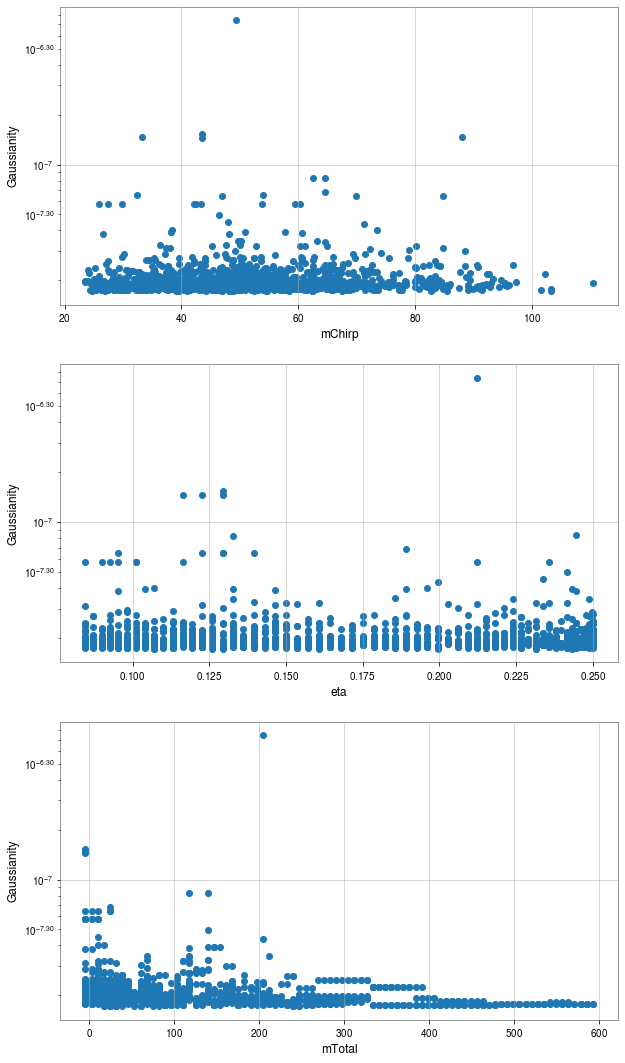

In [168]:
fig, ax = plt.subplots(3, figsize = [10, 30/1.61])

ax[0].scatter(regions['chirpMass'], regions['H1_chisq_Gaussian_Probability'])
ax[0].set_yscale('log')
# ax[0].set_xscale('log')
ax[0].set_xlabel("mChirp")
ax[0].set_ylabel("Gaussianity")

ax[1].scatter(regions['eta'], regions['H1_chisq_Gaussian_Probability'])
ax[1].set_yscale('log')
# ax[1].set_xscale('log')
ax[1].set_xlabel("eta")
ax[1].set_ylabel("Gaussianity")

ax[2].scatter(regions['xi'], regions['H1_chisq_Gaussian_Probability'])
ax[2].set_yscale('log')
# ax[2].set_xscale('log')
ax[2].set_xlabel("mTotal")
ax[2].set_ylabel("Gaussianity")


In [249]:
bankParameters = pd.read_csv('BankParameters/H1-BankParameters.csv').drop("Unnamed: 0", axis = 1)
bankParameters['chirpMass'] = bankParameters['mchirp'].values

1351 / 1352


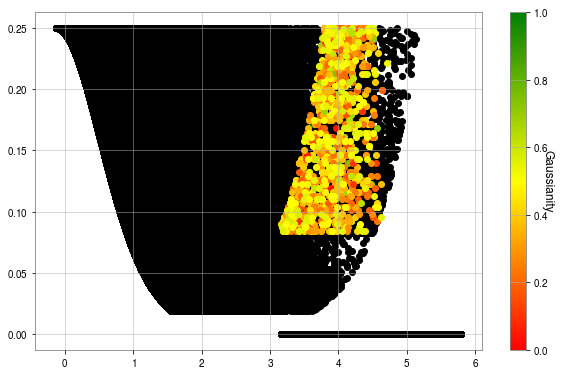

In [263]:
fig, ax = plt.subplots(figsize = [10, 10/1.61])

var = 'L1_snr_Gaussian_Probability'

minColor = np.log(min(regions[var]))
maxColor = np.log(max(regions[var]))

ax.scatter(np.log(bankParameters['chirpMass']), bankParameters['eta'], color = 'k')
for i in range(len(regions)):
    clear_output()
    print(str(i) + " / " + str(len(regions)))
    
    region = regions.iloc[i]
    x = np.log(region['chirpMass'])
    y = region['eta']
    val = np.log(region[var])
    color = cmap((val - minColor)/(maxColor - minColor))
    ax.scatter(x, y, color = color)
cbar = fig.colorbar(cm.ScalarMappable(norm = None, cmap=cmap), ax = ax)
cbar.set_label('Gaussianity', rotation=270)

1351 / 1352


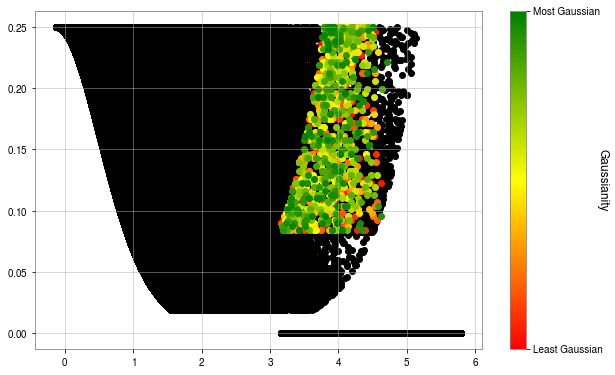

In [264]:
fig, ax = plt.subplots(figsize = [10, 10/1.61])

var = 'L1_snr_Gaussian_Probability'

regionsTemp = regions.sort_values(var)

minColor = 0
maxColor = len(regionsTemp)

ax.scatter(np.log(bankParameters['chirpMass']), bankParameters['eta'], color = 'k')

for i in range(len(regions)):
    clear_output()
    print(str(i) + " / " + str(len(regions)))
    
    region = regions.iloc[i]
    
    x = np.log(region['chirpMass'])
    y = region['eta']
    val = i
    color = cmap((val - minColor)/(maxColor - minColor))
    ax.scatter(x, y, color = color)
cbar = fig.colorbar(cm.ScalarMappable(norm = None, cmap=cmap), ax = ax)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Least Gaussian', 'Most Gaussian'])
cbar.set_label('Gaussianity', rotation=270)

### "Best" and "Worst" Region distribution

In [ ]:
bestRegionH1_snr = regions.dropna().sort_values('H1_snr_AD').iloc[0].name
bestRegionL1_snr = regions.dropna().sort_values('L1_snr_AD').iloc[0].name

worstRegionH1_snr = regions.dropna().sort_values('H1_snr_AD').iloc[-1].name
worstRegionL1_snr = regions.dropna().sort_values('L1_snr_AD').iloc[-1].name

fig, ax = plt.subplots(2, 2, figsize = [10, 10/1.61])

arr = list(regions.iloc[bestRegionH1_snr]['real_H1_snr']) + list(regions.iloc[bestRegionH1_snr]['real_L1_snr']) + list(regions.iloc[bestRegionH1_snr]['fake_H1_snr']) + list(regions.iloc[bestRegionH1_snr]['fake_L1_snr']);
bins = np.exp(np.linspace(np.log(min(arr)), np.log(max(arr)), num = int(np.sqrt(len(arr)/4))));

ax[0, 0].hist(regions.iloc[bestRegionH1_snr]['real_H1_snr'], color = 'red', density = True, bins = bins, alpha = 0.5)
ax[0, 0].hist(regions.iloc[bestRegionH1_snr]['fake_H1_snr'], color = 'yellow', density = True, bins = bins, alpha = 0.5)
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')
ax[0, 0].set_xlabel("snr")
ax[0, 0].set_ylabel('frequency')
ax[0, 0].set_title("SNR dist for the most well-behaved region for H1. N = " + str(len(regions.iloc[bestRegionH1_snr]['real_H1_snr'])))

arr = list(regions.iloc[bestRegionL1_snr]['real_H1_snr']) + list(regions.iloc[bestRegionL1_snr]['real_L1_snr']) + list(regions.iloc[bestRegionL1_snr]['fake_H1_snr']) + list(regions.iloc[bestRegionL1_snr]['fake_L1_snr']);
bins = np.exp(np.linspace(np.log(min(arr)), np.log(max(arr)), num = int(np.sqrt(len(arr)/4))));

ax[0, 1].hist(regions.iloc[bestRegionL1_snr]['real_L1_snr'], color = 'blue', density = True, bins = bins, alpha = 0.5)
ax[0, 1].hist(regions.iloc[bestRegionL1_snr]['fake_L1_snr'], color = 'yellow', density = True, bins = bins, alpha = 0.5)
ax[0, 1].set_xscale('log')
ax[0, 1].set_yscale('log')
ax[0, 1].set_xlabel("snr")
ax[0, 1].set_ylabel('frequency')
ax[0, 1].set_title("SNR dist for the most well-behaved region for L1. N = " + str(len(regions.iloc[bestRegionL1_snr]['real_L1_snr'])))

arr = list(regions.iloc[worstRegionH1_snr]['real_H1_snr']) + list(regions.iloc[worstRegionH1_snr]['real_L1_snr']) + list(regions.iloc[worstRegionH1_snr]['fake_H1_snr']) + list(regions.iloc[worstRegionH1_snr]['fake_L1_snr']);
bins = np.exp(np.linspace(np.log(min(arr)), np.log(max(arr)), num = int(np.sqrt(len(arr)/4))));

ax[1, 0].hist(regions.iloc[worstRegionH1_snr]['real_H1_snr'], color = 'red', density = True, bins = bins, alpha = 0.5)
ax[1, 0].hist(regions.iloc[worstRegionH1_snr]['fake_H1_snr'], color = 'yellow', density = True, bins = bins, alpha = 0.5)
ax[1, 0].set_xscale('log')
ax[1, 0].set_yscale('log')
ax[1, 0].set_xlabel("snr")
ax[1, 0].set_ylabel('frequency')
ax[1, 0].set_title("SNR dist for the least well-behaved region for H1. N = " + str(len(regions.iloc[worstRegionH1_snr]['real_H1_snr'])))

arr = list(regions.iloc[worstRegionL1_snr]['real_H1_snr']) + list(regions.iloc[worstRegionL1_snr]['real_L1_snr']) + list(regions.iloc[worstRegionL1_snr]['fake_H1_snr']) + list(regions.iloc[worstRegionL1_snr]['fake_L1_snr']);
bins = np.exp(np.linspace(np.log(min(arr)), np.log(max(arr)), num = int(np.sqrt(len(arr)/4))));

ax[1, 1].hist(regions.iloc[worstRegionL1_snr]['real_L1_snr'], color = 'blue', density = True, bins = bins, alpha = 0.5)
ax[1, 1].hist(regions.iloc[worstRegionL1_snr]['fake_L1_snr'], color = 'yellow', density = True, bins = bins, alpha = 0.5)
ax[1, 1].set_xscale('log')
ax[1, 1].set_yscale('log')
ax[1, 1].set_xlabel("snr")
ax[1, 1].set_ylabel('frequency')
ax[1, 1].set_title("SNR dist for the least well-behaved region for L1. N = " + str(len(regions.iloc[worstRegionL1_snr]['real_L1_snr'])))


fig.tight_layout()

In [ ]:
# fig.savefig("ResultsPlots/Distribution_Of_Snr_Of_Best_And_Worst_Regions.png")
fig.savefig("ResultsPlots/Distribution_Of_Snr_Of_Best_And_Worst_Regions_eta_logMchirp.png")

In [ ]:
bestRegionH1_chisq = regions.dropna().sort_values('H1_chisq_AD').iloc[0].name
bestRegionL1_chisq = regions.dropna().sort_values('L1_chisq_AD').iloc[0].name

worstRegionH1_chisq = regions.dropna().sort_values('H1_chisq_AD').iloc[-1].name
worstRegionL1_chisq = regions.dropna().sort_values('L1_chisq_AD').iloc[-1].name

fig, ax = plt.subplots(2, 2, figsize = [10, 10/1.61])

arr = list(regions.iloc[bestRegionH1_chisq]['real_H1_chisq']) + list(regions.iloc[bestRegionH1_chisq]['real_L1_chisq']) + list(regions.iloc[bestRegionH1_chisq]['fake_H1_chisq']) + list(regions.iloc[bestRegionH1_chisq]['fake_L1_chisq']);
bins = np.exp(np.linspace(np.log(min(arr)), np.log(max(arr)), num = int(np.sqrt(len(arr)/4))));

ax[0, 0].hist(regions.iloc[bestRegionH1_chisq]['real_H1_chisq'], color = 'red', density = True, bins = bins, alpha = 0.5)
ax[0, 0].hist(regions.iloc[bestRegionH1_chisq]['fake_H1_chisq'], color = 'yellow', density = True, bins = bins, alpha = 0.5)
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')
ax[0, 0].set_xlabel("chisq")
ax[0, 0].set_ylabel('frequency')
ax[0, 0].set_title("chisq dist for the most well-behaved region for H1. N = " + str(len(regions.iloc[bestRegionH1_chisq]['real_H1_chisq'])))

arr = list(regions.iloc[bestRegionL1_chisq]['real_H1_chisq']) + list(regions.iloc[bestRegionL1_chisq]['real_L1_chisq']) + list(regions.iloc[bestRegionL1_chisq]['fake_H1_chisq']) + list(regions.iloc[bestRegionL1_chisq]['fake_L1_chisq']);
bins = np.exp(np.linspace(np.log(min(arr)), np.log(max(arr)), num = int(np.sqrt(len(arr)/4))));

ax[0, 1].hist(regions.iloc[bestRegionL1_chisq]['real_L1_chisq'], color = 'blue', density = True, bins = bins, alpha = 0.5)
ax[0, 1].hist(regions.iloc[bestRegionL1_chisq]['fake_L1_chisq'], color = 'yellow', density = True, bins = bins, alpha = 0.5)
ax[0, 1].set_xscale('log')
ax[0, 1].set_yscale('log')
ax[0, 1].set_xlabel("chisq")
ax[0, 1].set_ylabel('frequency')
ax[0, 1].set_title("chisq dist for the most well-behaved region for L1. N = " + str(len(regions.iloc[bestRegionL1_chisq]['real_L1_chisq'])))

arr = list(regions.iloc[worstRegionH1_chisq]['real_H1_chisq']) + list(regions.iloc[worstRegionH1_chisq]['real_L1_chisq']) + list(regions.iloc[worstRegionH1_chisq]['fake_H1_chisq']) + list(regions.iloc[worstRegionH1_chisq]['fake_L1_chisq']);
bins = np.exp(np.linspace(np.log(min(arr)), np.log(max(arr)), num = int(np.sqrt(len(arr)/4))));

ax[1, 0].hist(regions.iloc[worstRegionH1_chisq]['real_H1_chisq'], color = 'red', density = True, bins = bins, alpha = 0.5)
ax[1, 0].hist(regions.iloc[worstRegionH1_chisq]['fake_H1_chisq'], color = 'yellow', density = True, bins = bins, alpha = 0.5)
ax[1, 0].set_xscale('log')
ax[1, 0].set_yscale('log')
ax[1, 0].set_xlabel("chisq")
ax[1, 0].set_ylabel('frequency')
ax[1, 0].set_title("chisq dist for the least well-behaved region for H1. N = " + str(len(regions.iloc[worstRegionH1_chisq]['real_H1_chisq'])))

arr = list(regions.iloc[worstRegionL1_chisq]['real_H1_chisq']) + list(regions.iloc[worstRegionL1_chisq]['real_L1_chisq']) + list(regions.iloc[worstRegionL1_chisq]['fake_H1_chisq']) + list(regions.iloc[worstRegionL1_chisq]['fake_L1_chisq']);
bins = np.exp(np.linspace(np.log(min(arr)), np.log(max(arr)), num = int(np.sqrt(len(arr)/4))));

ax[1, 1].hist(regions.iloc[worstRegionL1_chisq]['real_L1_chisq'], color = 'blue', density = True, bins = bins, alpha = 0.5)
ax[1, 1].hist(regions.iloc[worstRegionL1_chisq]['fake_L1_chisq'], color = 'yellow', density = True, bins = bins, alpha = 0.5)
ax[1, 1].set_xscale('log')
ax[1, 1].set_yscale('log')
ax[1, 1].set_xlabel("chisq")
ax[1, 1].set_ylabel('frequency')
ax[1, 1].set_title("chisq dist for the least well-behaved region for L1. N = " + str(len(regions.iloc[worstRegionL1_chisq]['real_L1_chisq'])))


fig.tight_layout()

In [ ]:
# fig.savefig("ResultsPlots/Distribution_Of_Chisq_Of_Best_And_Worst_Regions.png")
fig.savefig("ResultsPlots/Distribution_Of_Chisq_Of_Best_And_Worst_Regions_eta_logMchirp.png")

---

### Reading Banks SVD Files to recover the bank parameters (tau0 and tau3 mostly)

In [187]:
def getSVDBankParams(svdBankFile):

    with gzip.open(svdBankFile, 'rb') as f:
        svdFile = f.read().decode('ascii').split('\n')

    columns = []
    sigInspiralDict = {}

    dataStarts = []
    i = 0
    for line in svdFile:
        if 'Gamma0' in line:
            dataStarts += [i]
        i += 1
    for start in dataStarts:
        columnStart = start
        columnEnd = columnStart
        while 'Delimiter' not in svdFile[columnEnd]:
            columnEnd += 1    
        dataStart = columnEnd
        while '<' in svdFile[dataStart]:
            dataStart += 1
        dataEnd = dataStart
        while '<' not in svdFile[dataEnd]:
            dataEnd += 1

        if len(columns) == 0:
            for line in svdFile[columnStart:columnEnd]:
                columnName = line.split('=',1)[-1].split('=',1)[-1].split('\"')[1]
                columns += [columnName]
                sigInspiralDict[columnName] = []
        for line in svdFile[dataStart:dataEnd]:
            values = line.replace('\t','').split(',')
            for i in range(len(columns)):
                if '\"' in values[i]:
                    sigInspiralDict[columns[i]] += [values[i].replace('\"','')]
                else:
                    sigInspiralDict[columns[i]] += [eval(values[i])]
    return sigInspiralDict

columnsKeep = ['eta', 'event_id', 'f_final', 'mass1', 'mass2', 'mchirp',\
       'mtotal', 'sigmasq', 'snr', 'spin1x', 'spin1y', 'spin1z', 'spin2x',\
       'spin2y', 'spin2z', 'tau0', 'tau3', 'template_duration']


minMass = 1000000
minBank = 0
for ifo in ['H1', 'L1', 'V1']:
    bankParameters = pd.DataFrame({})
    for num in range(1757 + 1):
        numString = str(num).zfill(4)
        svdFileName = '/home/gstlalcbc.offline/observing/3/b/C00/chunk24_1257388107_1258128955/gstlal_svd_bank/' + ifo + '-' + numString + '_SVD-1257388107-740848.xml.gz'
        if len(bankParameters) == 0:
            bankParametersTemp = getSVDBankParams(svdFileName)
            bankParameters = bankParametersTemp.copy()
        else:
            #bankParameters = bankParameters.append(getSVDBankParams(svdFileName))
            bankParametersTemp = getSVDBankParams(svdFileName)
            for key in bankParameters.keys():
                bankParameters[key] += bankParametersTemp[key]
        mass = np.mean(bankParameters['mass1']) + np.mean(bankParameters['mass2'])
        if mass < minMass:
            minMass = mass
            minBank = num
        clear_output()
        print(ifo + " --- " + numString + " --- " + str(len(bankParameters['Gamma0'])))
        print("Smallest Mass: " + str(minMass))
        print("Smallest Mass Bank: " + str(minBank))
        print("This Bank's Mass: " + str(mass))
        
#     pd.DataFrame(bankParameters)[columnsKeep].drop_duplicates().sort_index().to_csv('BankParameters/' + ifo + '-BankParameters.csv')

H1 --- 0081 --- 82245
Smallest Mass: 6.060810422854291
Smallest Mass Bank: 0
This Bank's Mass: 6.511610813312663



KeyboardInterrupt



In [7]:
import gzip
incompleteRegions = regions[]
for num in range(1757 + 1):
    numString = str(num).zfill(4)
    
    f = '/home/gstlalcbc.offline/observing/3/b/C00/chunk24_1257388107_1258128955/gstlal_svd_bank/H1-0001_SVD-1257388107-740848.xml.gz'
    bankParameters = pd.DataFrame(getSVDBankParams(fileTemp))
    

{'Gamma0': [6831479,
  6780051,
  6791251,
  6775413,
  6824653,
  6797445,
  6790991,
  6820795,
  6816087,
  6813709,
  6816931,
  6832146,
  6812179,
  6820381,
  6799489,
  6771724,
  6801725,
  6826907,
  6830223,
  6828727,
  6816769,
  6791394,
  6791919,
  6807078,
  6810580,
  6826358,
  6819498,
  6831802,
  6808091,
  6756784,
  6816933,
  6831192,
  6766913,
  6817971,
  6805114,
  6812677,
  6824193,
  6775944,
  6829732,
  6806845,
  6767007,
  6814481,
  6811686,
  6816949,
  6770145,
  6780488,
  6825993,
  6831447,
  6806873,
  6799797,
  6802282,
  6782248,
  6826260,
  6813816,
  6828987,
  6830928,
  6799359,
  6808819,
  6808266,
  6820992,
  6770248,
  6814377,
  6790865,
  6802830,
  6825716,
  6832054,
  6788025,
  6801022,
  6779516,
  6801466,
  6812151,
  6777506,
  6801052,
  6779645,
  6808610,
  6814444,
  6817179,
  6826508,
  6832233,
  6817927,
  6784708,
  6826033,
  6811778,
  6823718,
  6811644,
  6809593,
  6717591,
  6788651,
  6799072,
  6810218,


In [8]:
bankParameters = pd.DataFrame(getSVDBankParams(fileTemp))

In [ ]:
regions

In [126]:
temp.columns[1:]

Index(['Gamma0', 'eta', 'event_id', 'f_final', 'mass1', 'mass2', 'mchirp',
       'mtotal', 'sigmasq', 'snr', 'spin1x', 'spin1y', 'spin1z', 'spin2x',
       'spin2y', 'spin2z', 'tau0', 'tau3', 'template_duration'],
      dtype='object')

In [ ]:
with open("regions_1000.pkl", 'rb') as f:
    regions = pkl.load(f)

 In this paper we explore the performance of the distribution of gstlal trigger parameters  $\left(\rho, \xi^2\right)$  in different regions of some parameter space. The comparison is made by quantifying the difference between the distribution of these parameters on real H1 and L1 data, with that of noise-curve-generated gaussian data.\\
		 We discover that regions representative of high $\mathcal{M}_{chirp}$ and low $\eta$ tend to present a greater deviation from Gaussianity.

In [ ]:
We explore the differences of results of GW searches with the gstlal pipeline/method applied to real LIGO data and simulated gaussian data.\
This difference is quantified with the Andre-Gaby test and find out sigfinicant differences depending on bank parameters such as chirp mass and symmetric mass ratio.
We find that regions representative of high chirp mass are x times worse than those of low chirp mass. and any other stuff I find here.
Maybe something about glitches and # of triggers.
